In [2]:
# In this file I can accurately ray trace
# determine the area of a the mesh using ray tracing
import shapely
import shapely.plotting
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

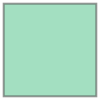

In [3]:
x_min = 0
x_max = 10
y_min = 0
y_max = 10

problem_domain = shapely.geometry.box(x_min, y_min, x_max, y_max)
problem_domain

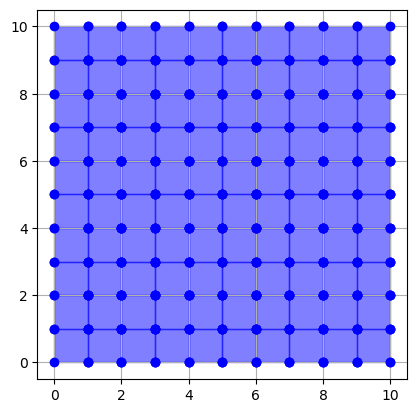

In [4]:
resolution = 1

x = np.arange(x_min, x_max + resolution, resolution)
y = np.arange(y_min, y_max + resolution, resolution)


cells = []
for i in range(len(x)-1):
    for j in range(len(y)-1):
        cell = shapely.geometry.box(x[i], y[j], x[i+1], y[j+1])
        cells.append(cell)
    
for cell in cells:
    shapely.plotting.plot_polygon(cell, color='blue', alpha=0.5)
    
tree = shapely.STRtree(cells)

In [4]:
ray_width = 0.1

# angle = np.pi / 6
# angle = np.pi / 4


def generate_ray(
    offset_from_center, line_angle, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max
):
    """Generates a ray an angle `line_angle` that is offset by `offset_from_center` from the center of the problem domain
    in the direction perpendicular to the line angle.
    The ray is bounded by the problem domain.
    Theta is in radians and counterclockwise from the x-axis.
    """
    sin_theta = np.sin(line_angle)
    cos_theta = np.cos(line_angle)
    tan_theta = sin_theta / cos_theta

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # technically not the offset but just a point on the ray we are generating
    x_offset = x_center + offset_from_center * sin_theta
    y_offset = y_center - offset_from_center * cos_theta

    # point intercept form, slope is tan(theta)
    y_of_x = lambda x: tan_theta * (x - x_offset) + y_offset
    x_of_y = lambda y: (y - y_offset) / tan_theta + x_offset

    # edge case where ray intersects corners of the problem domain
    if (
        np.abs(x_max - x_min) == np.abs(y_max - y_min)
        and np.abs(line_angle) == np.pi / 4
        and offset_from_center == 0
    ):
        if line_angle > 0:
            return shapely.geometry.LineString([(x_min, y_min), (x_max, y_max)])
        else:
            return shapely.geometry.LineString([(x_min, y_max), (x_max, y_min)])

    # Calculate the intersection points with the problem domain boundaries
    points = []
    y_of_x_min = y_of_x(x_min)
    if y_min <= y_of_x_min <= y_max:
        points.append((x_min, y_of_x_min))

    y_of_x_max = y_of_x(x_max)
    if y_min <= y_of_x_max <= y_max:
        points.append((x_max, y_of_x_max))

    x_of_y_min = x_of_y(y_min)
    if x_min <= x_of_y_min <= x_max:
        points.append((x_of_y_min, y_min))

    x_of_y_max = x_of_y(y_max)
    if x_min <= x_of_y_max <= x_max:
        points.append((x_of_y_max, y_max))

    if len(points) == 0:
        return None

    assert (
        len(points) == 2
    ), f"Ray does not intersect the problem domain twice. It does {len(points)} times. Points: {points}"

    # Create a line string representing the ray
    ray = shapely.geometry.LineString(points)

    return ray



C:\Users\bpeco\AppData\Local\Temp\ipykernel_18900\661280314.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


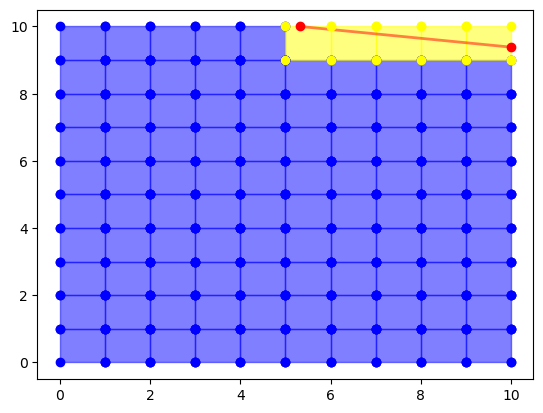

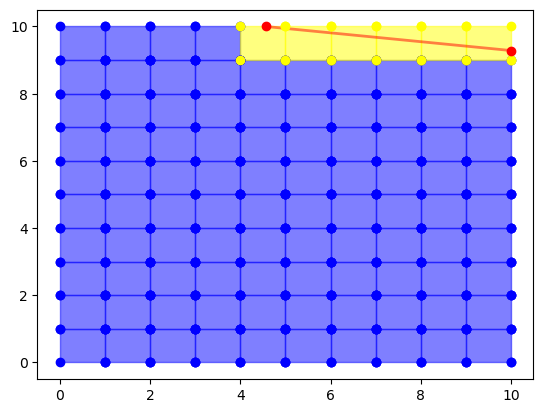

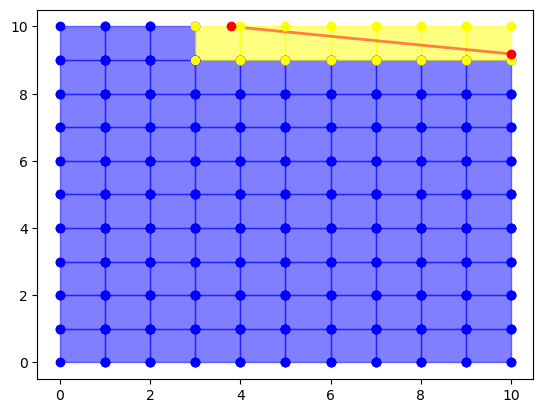

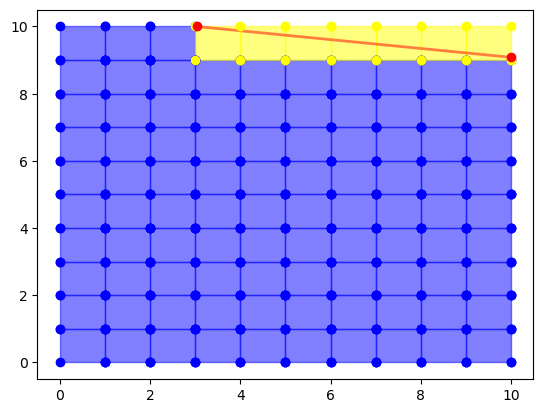

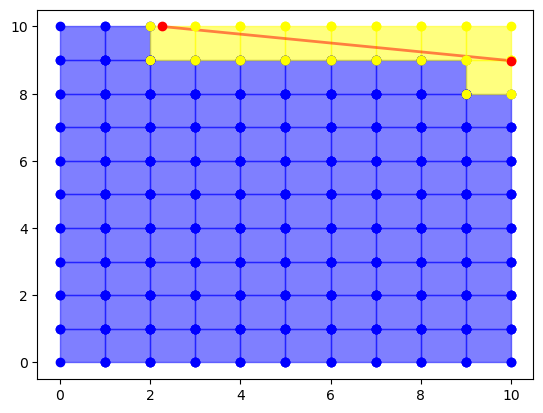

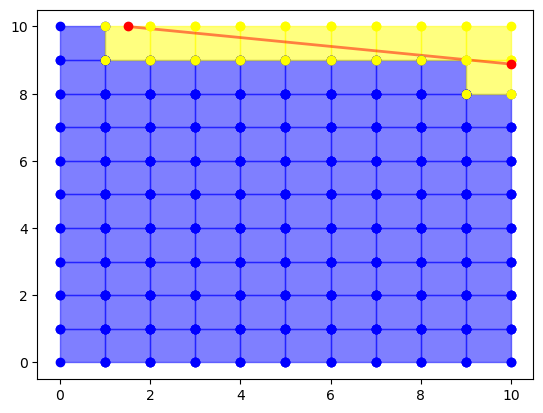

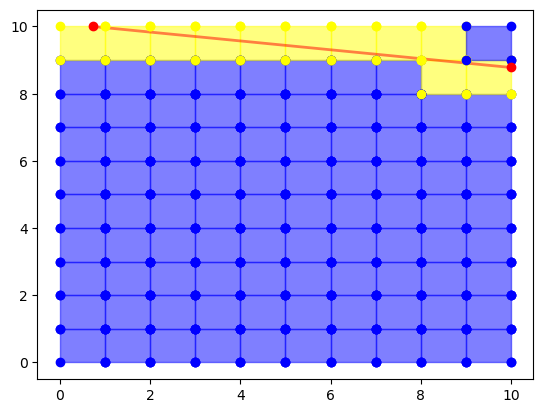

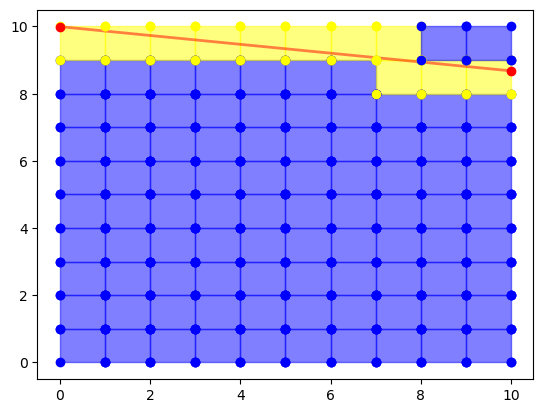

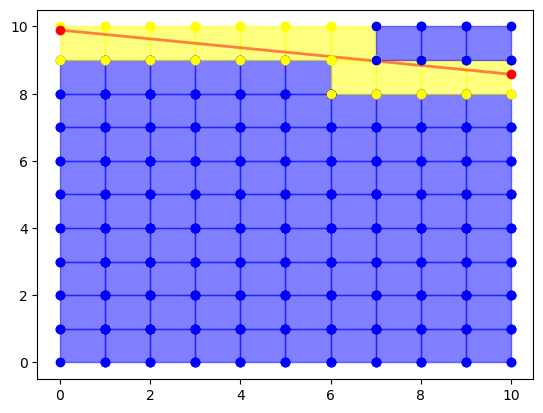

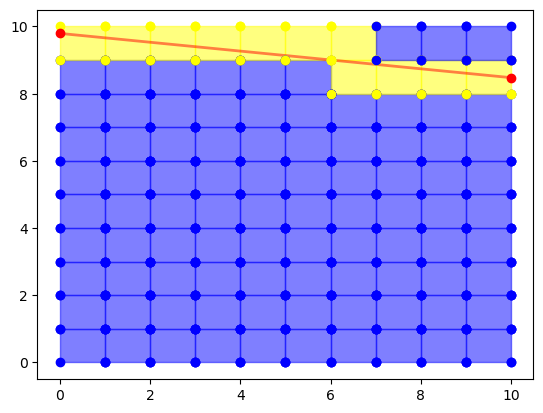

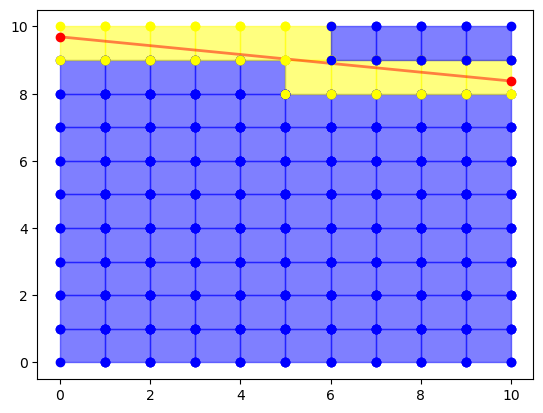

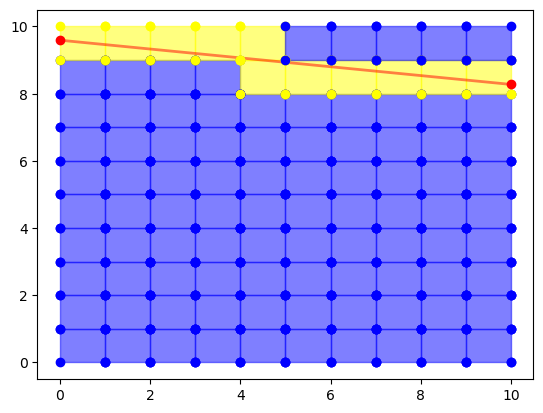

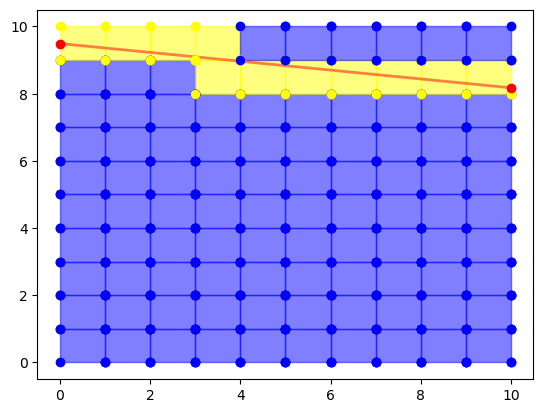

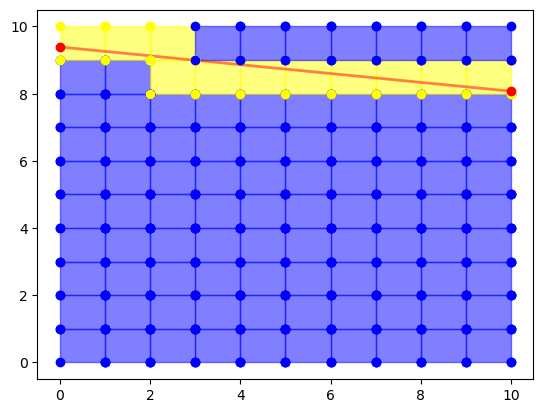

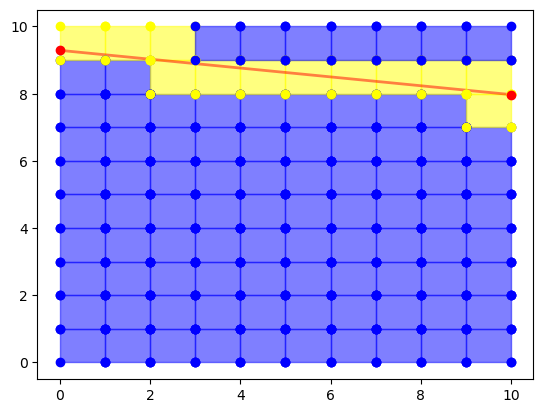

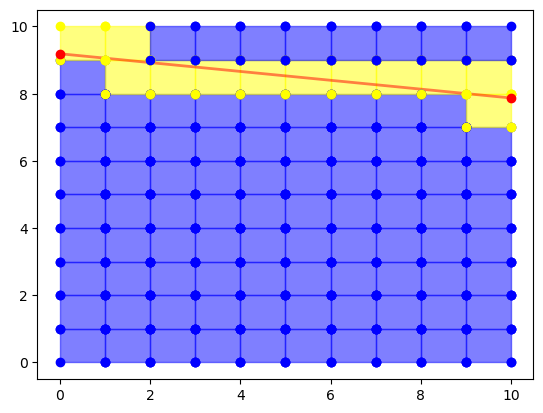

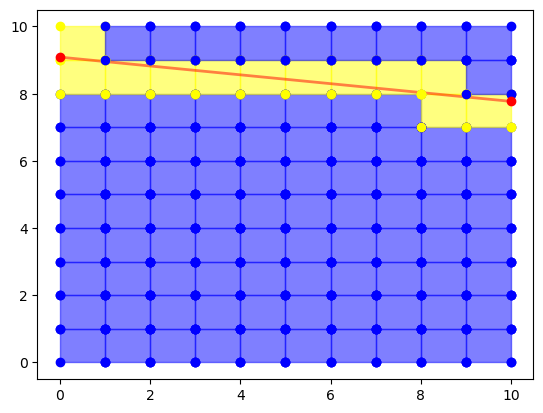

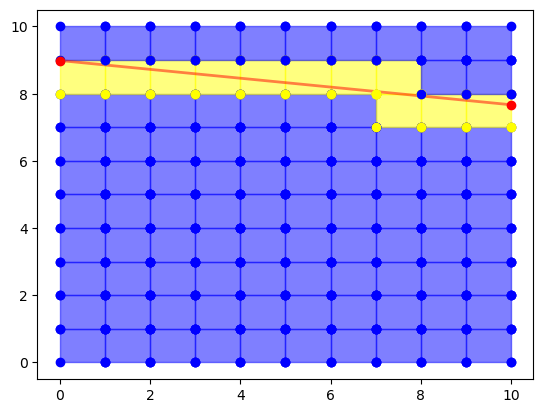

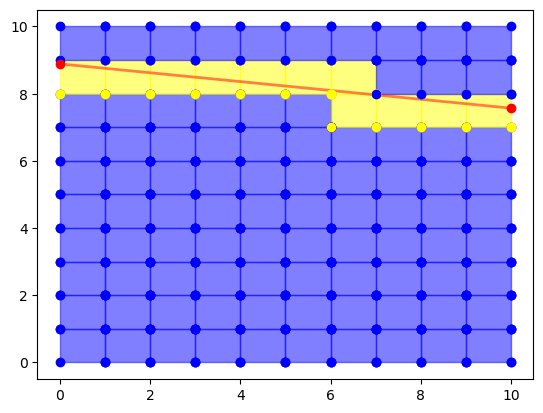

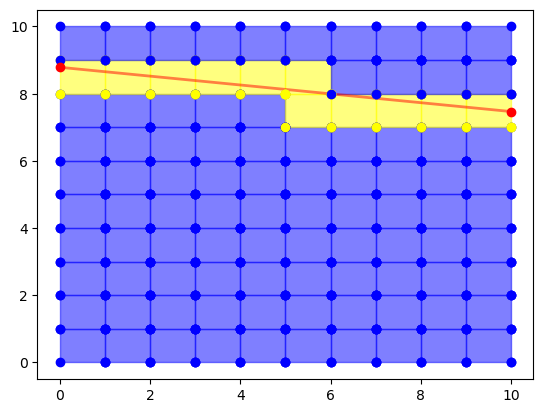

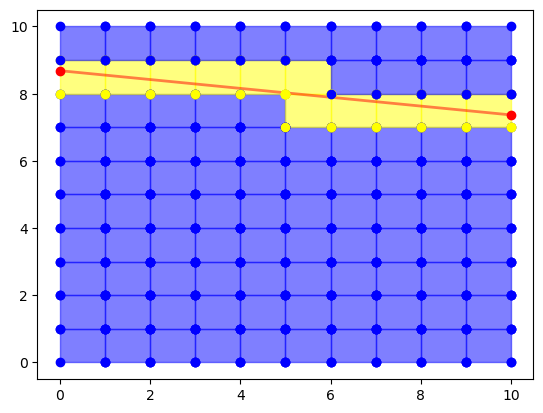

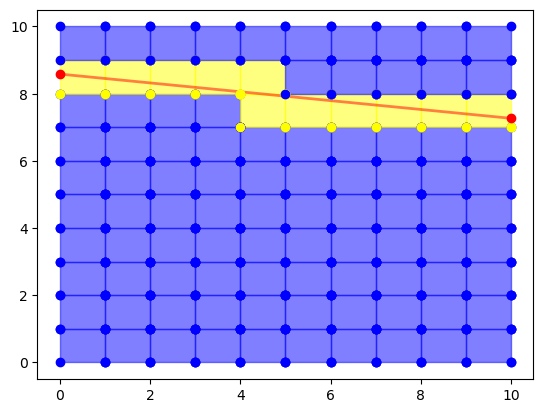

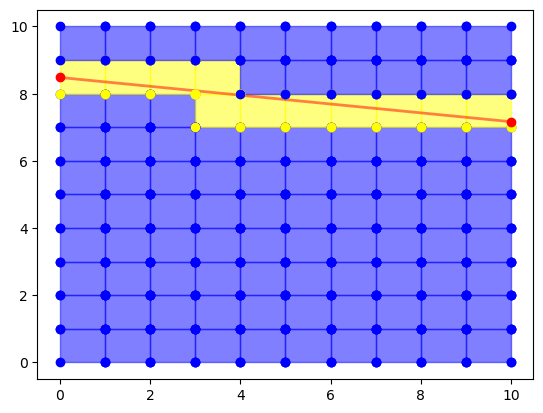

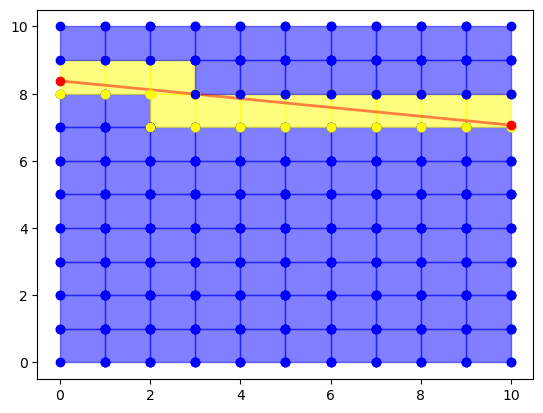

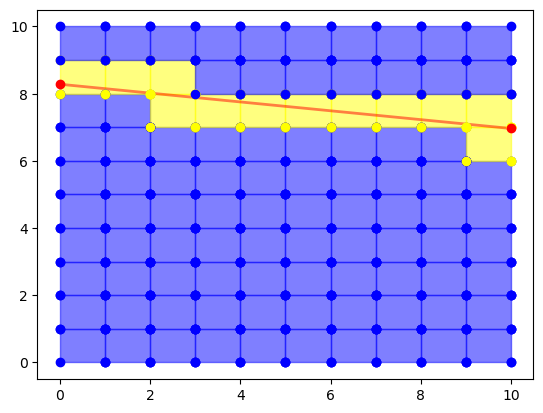

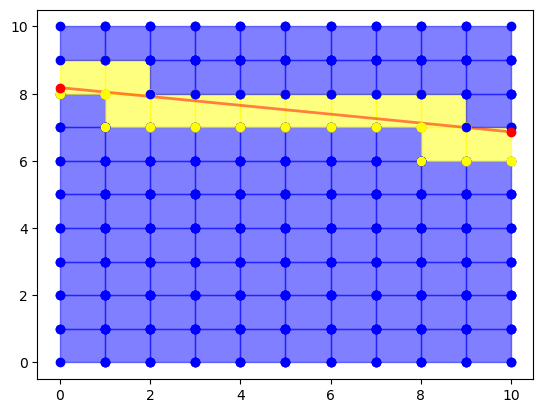

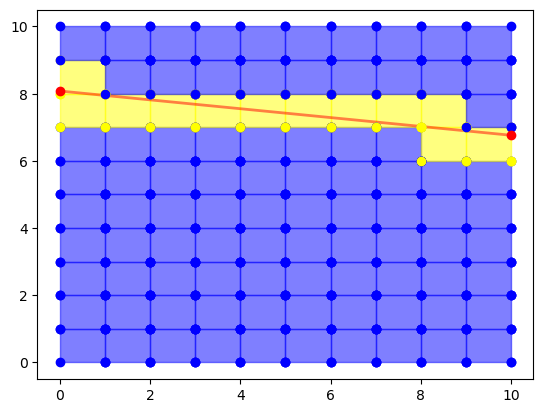

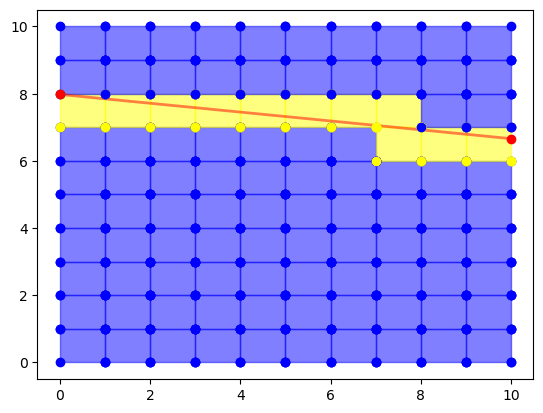

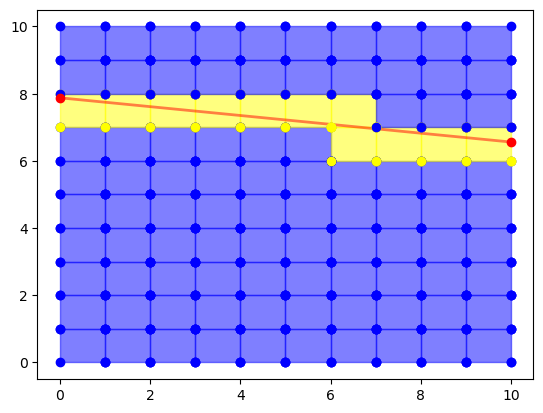

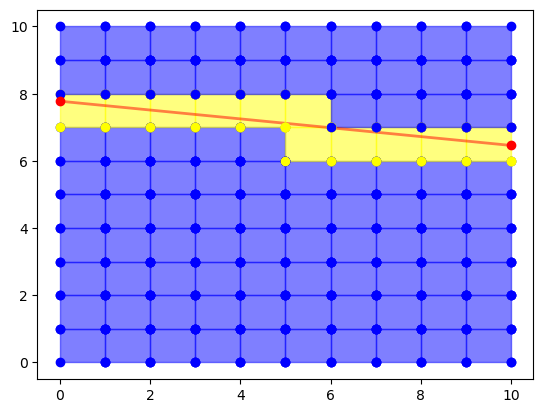

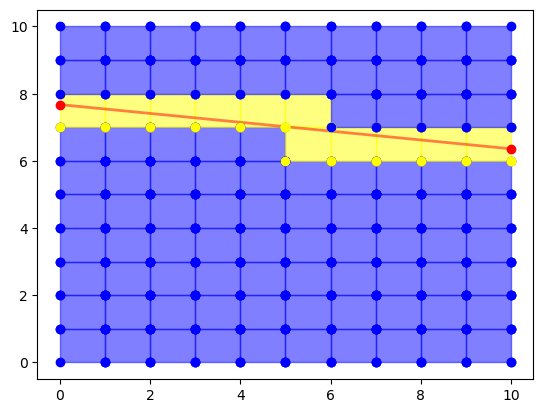

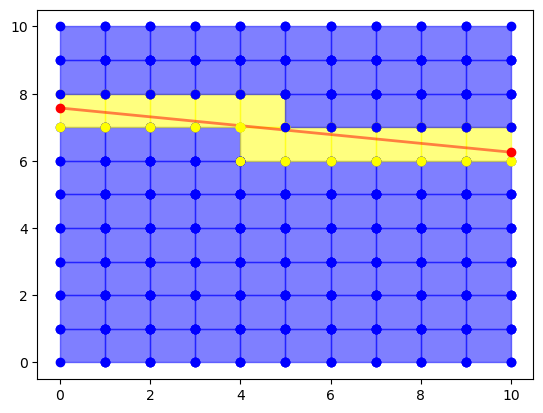

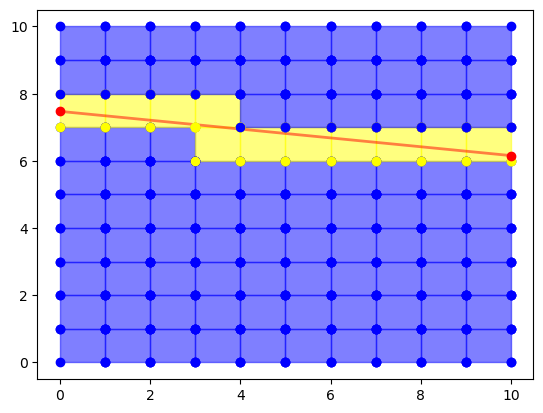

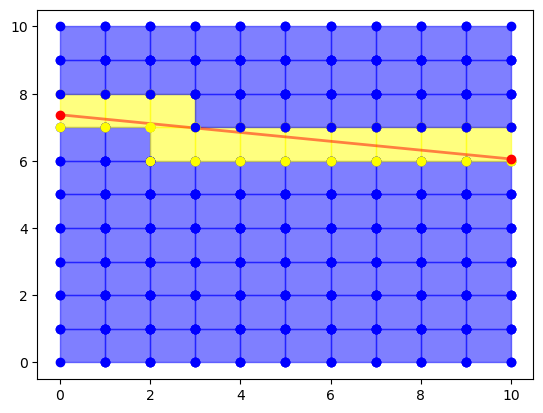

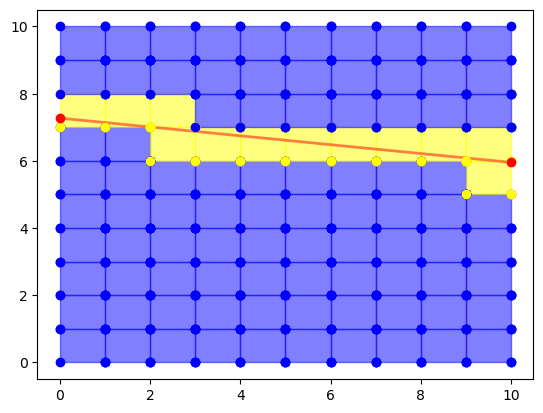

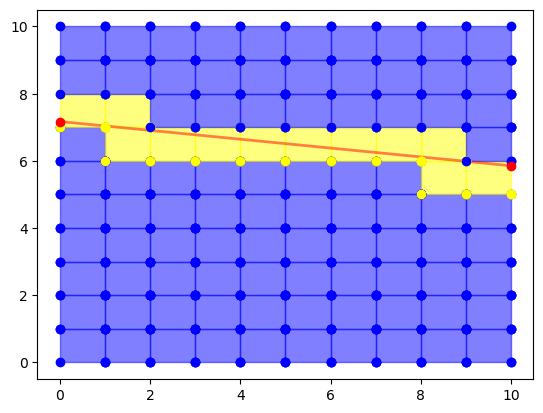

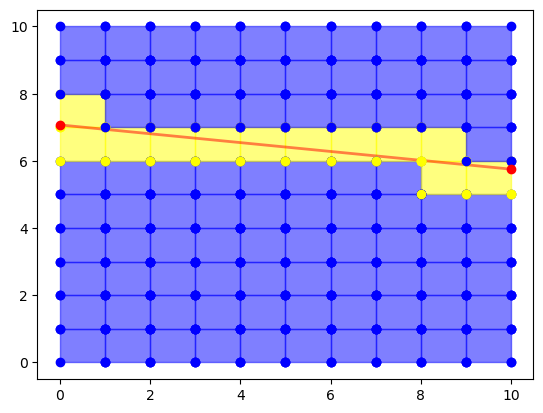

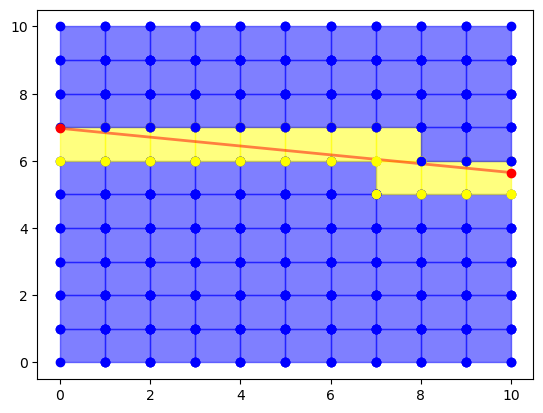

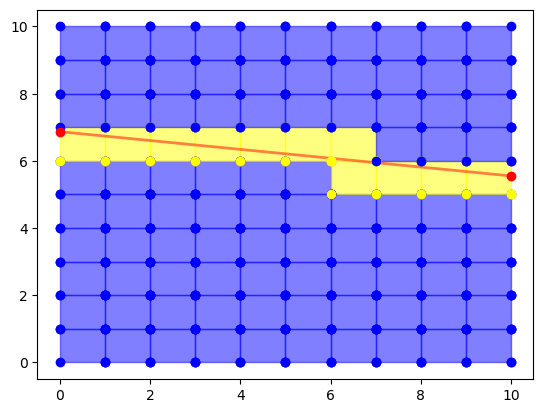

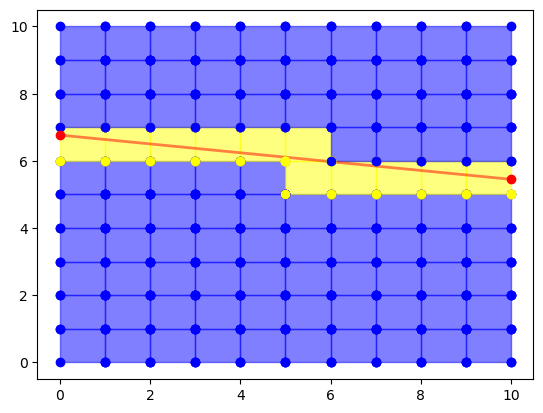

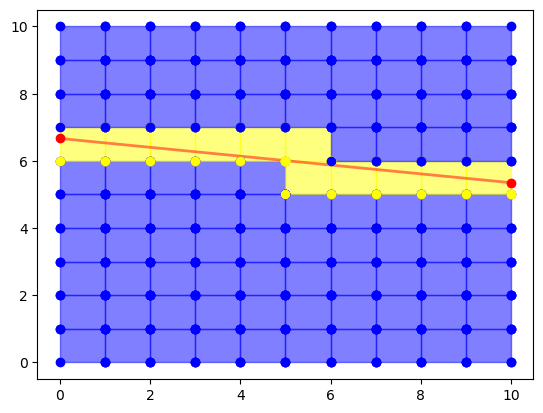

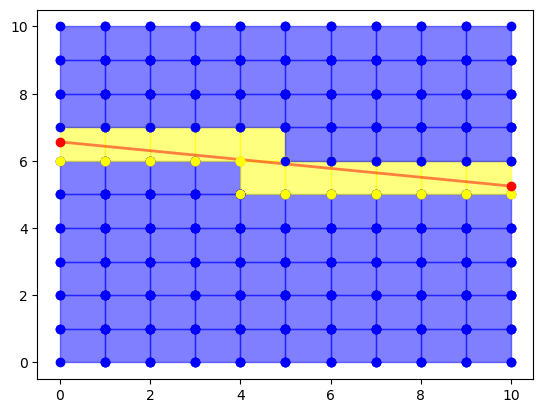

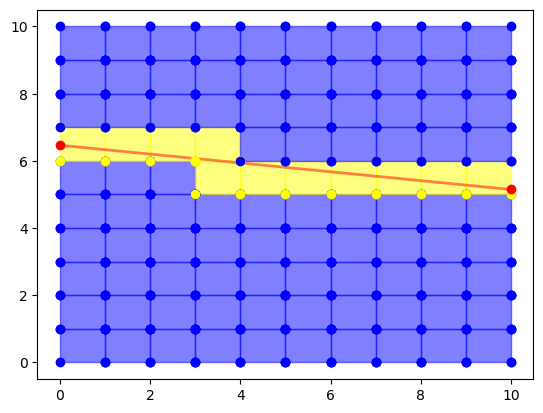

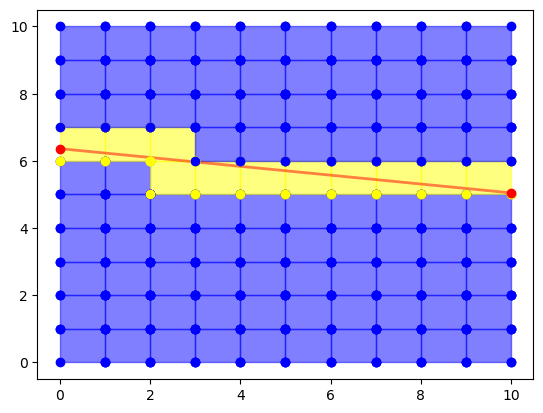

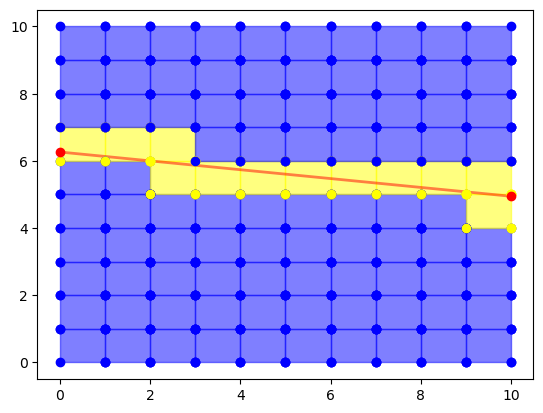

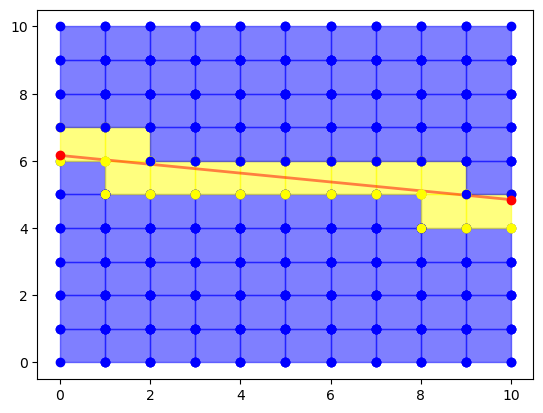

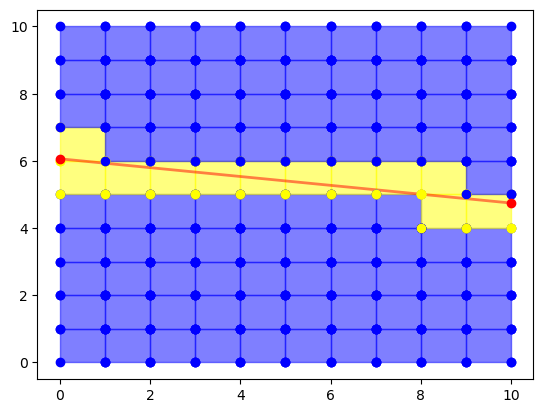

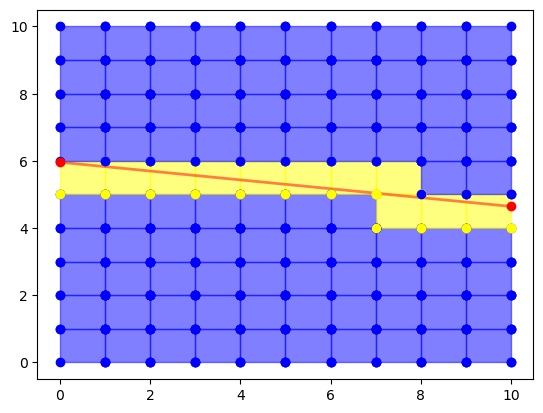

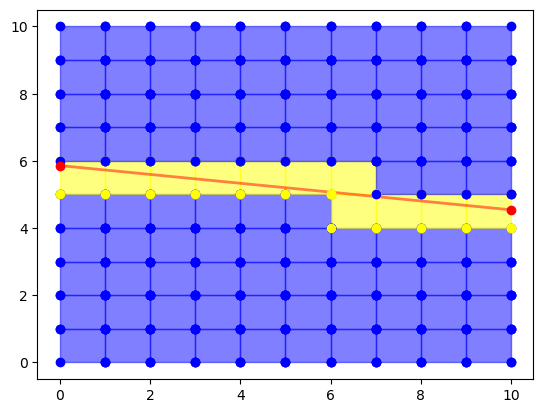

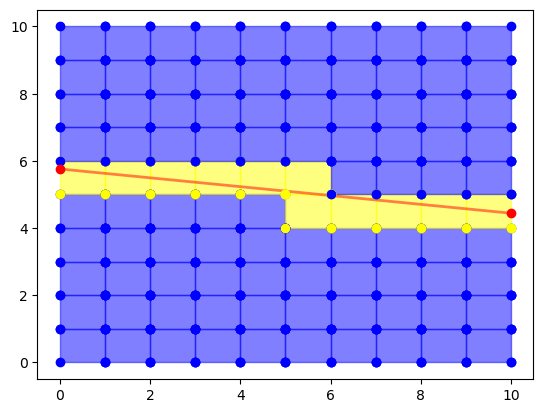

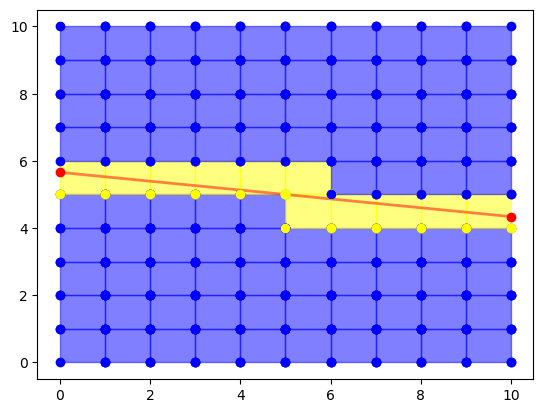

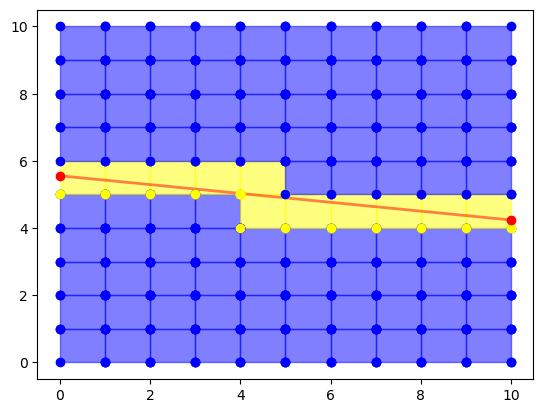

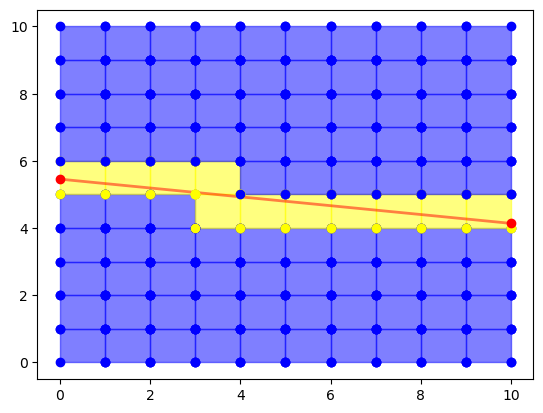

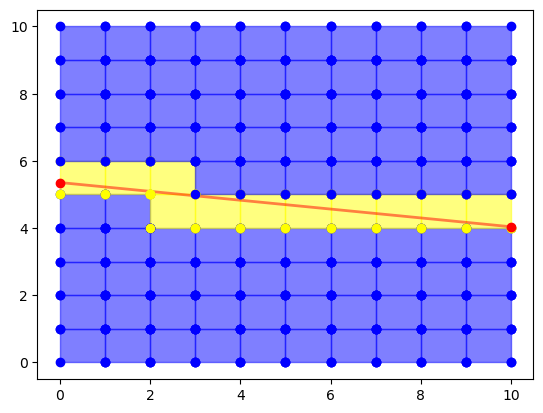

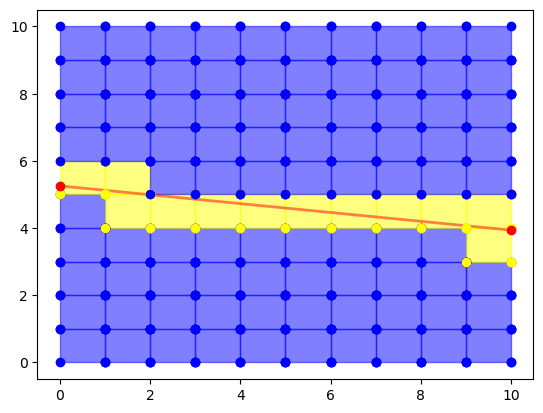

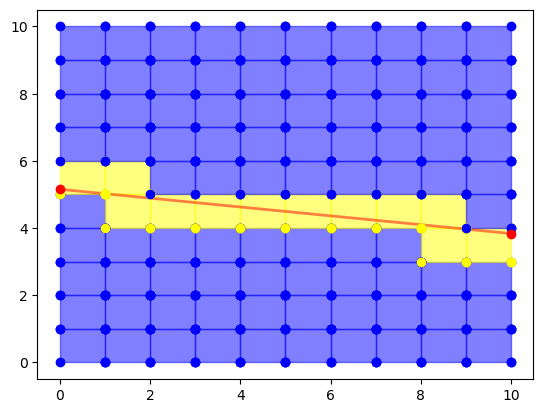

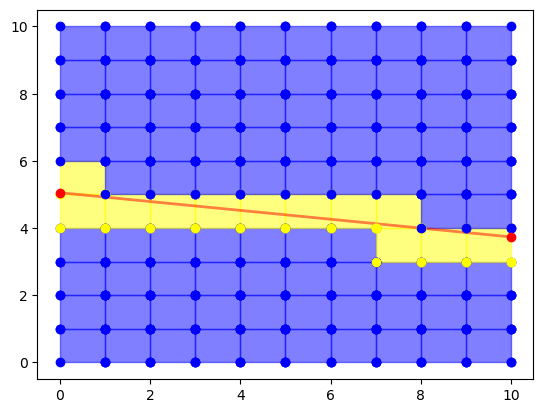

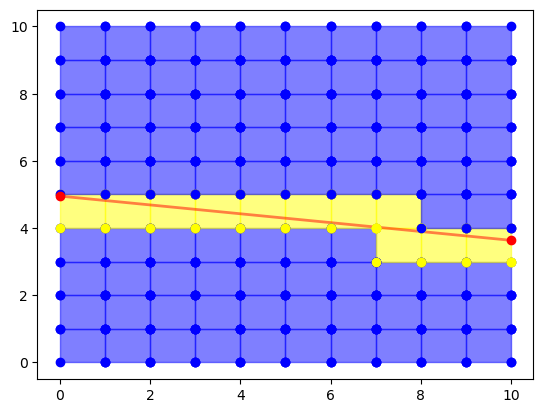

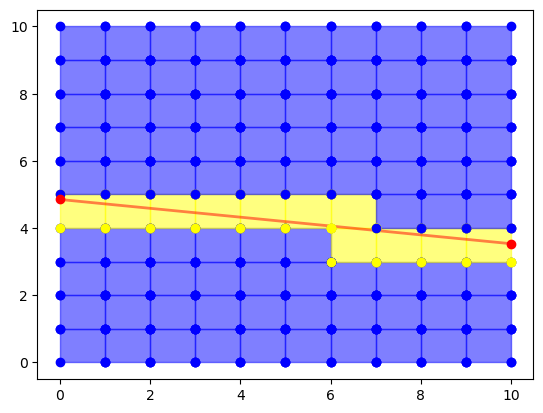

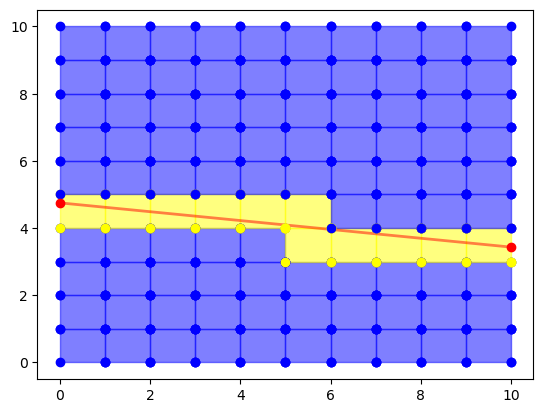

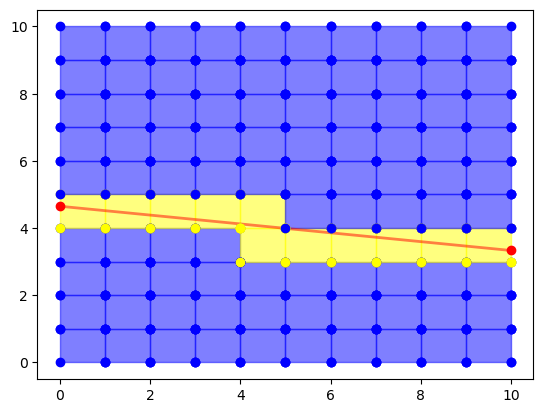

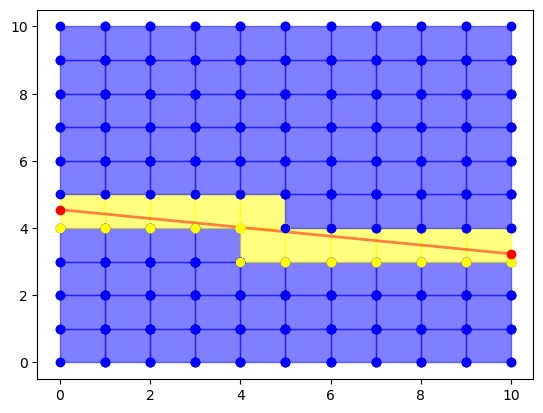

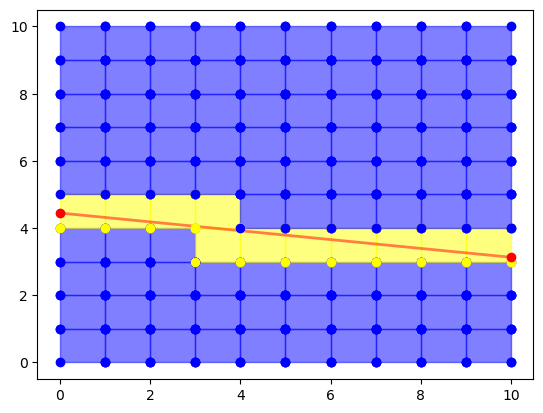

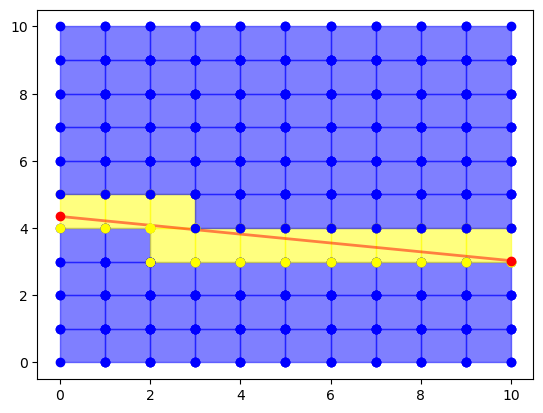

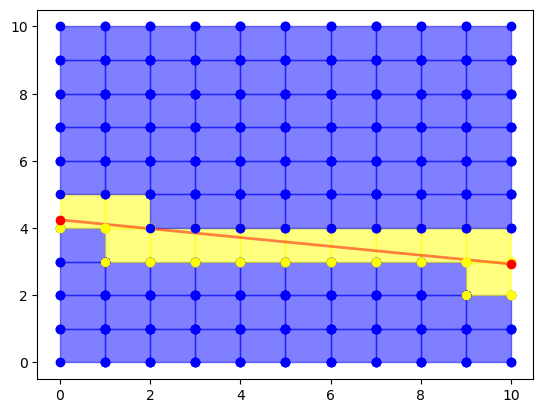

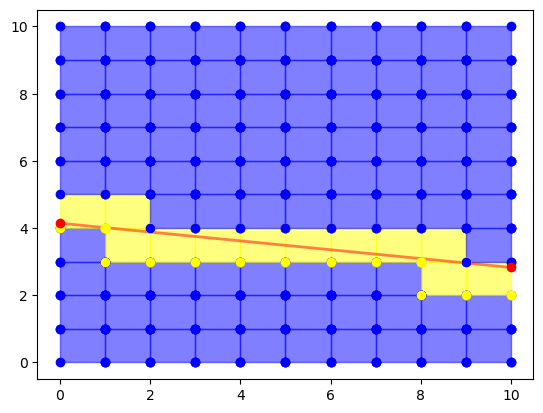

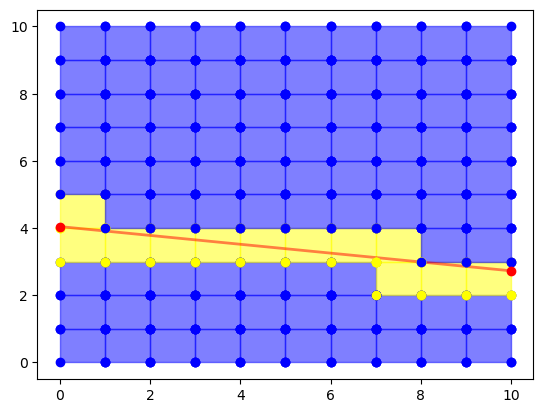

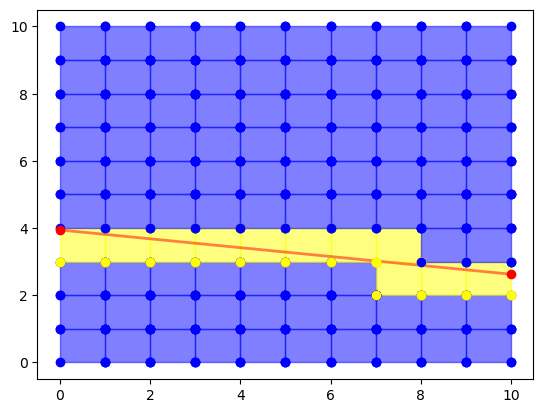

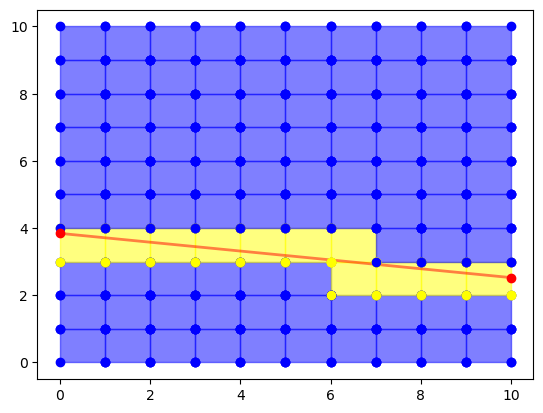

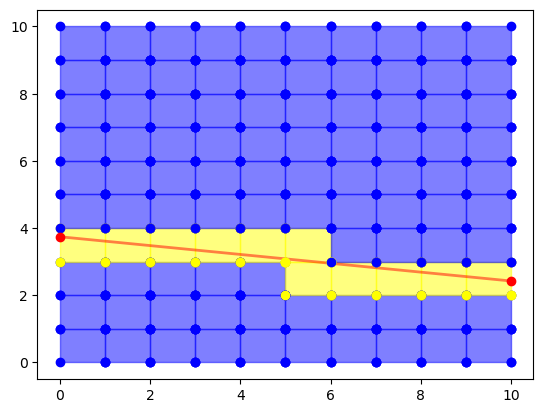

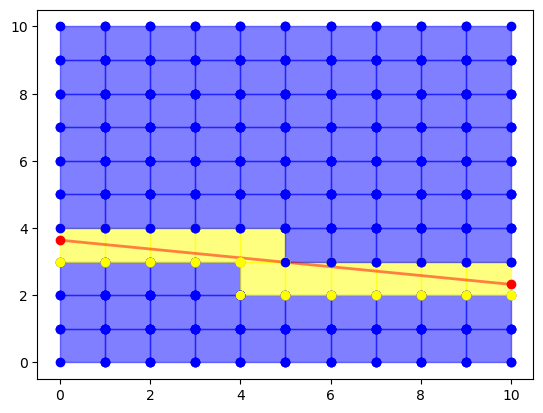

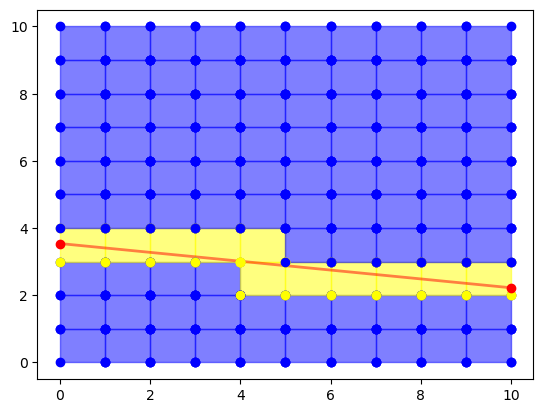

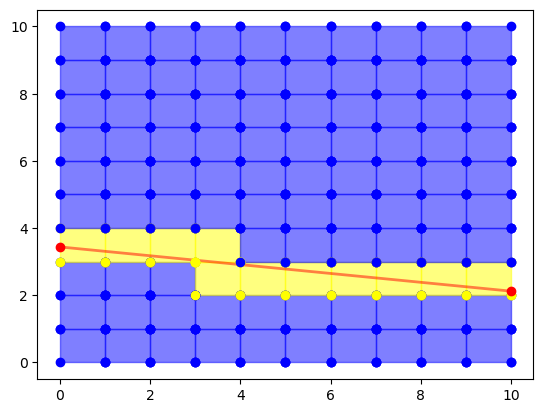

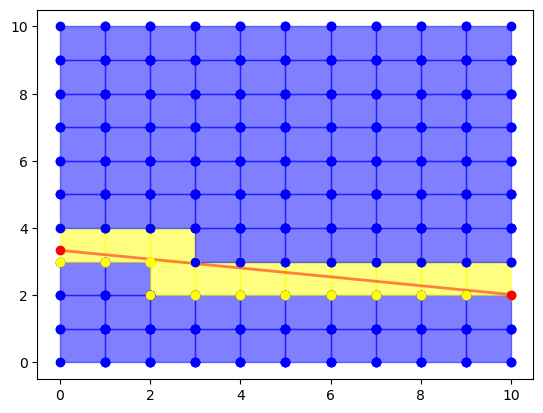

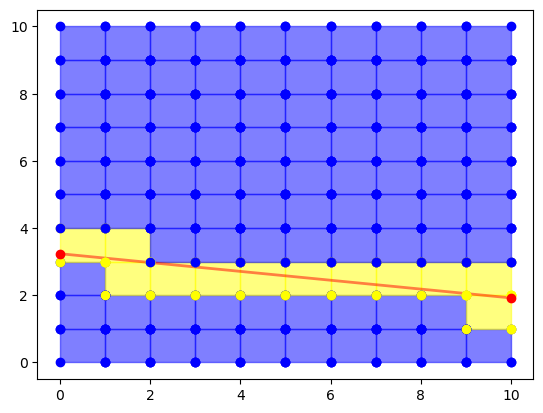

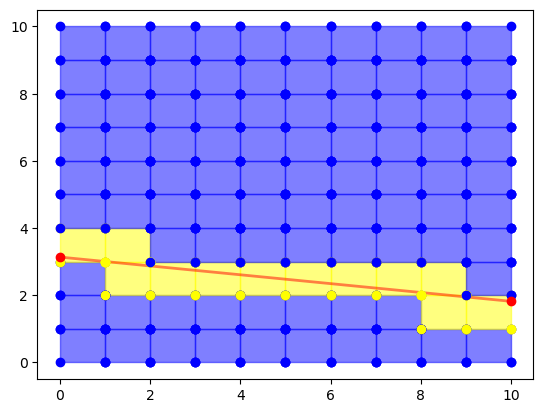

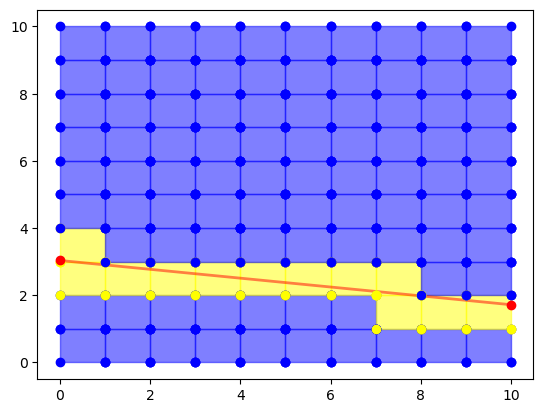

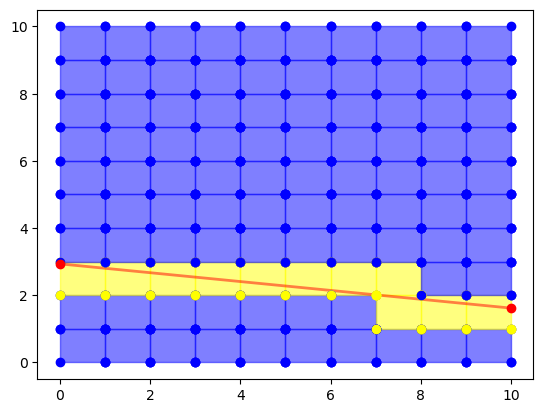

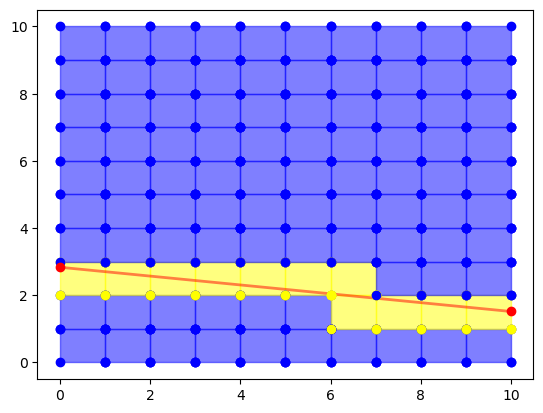

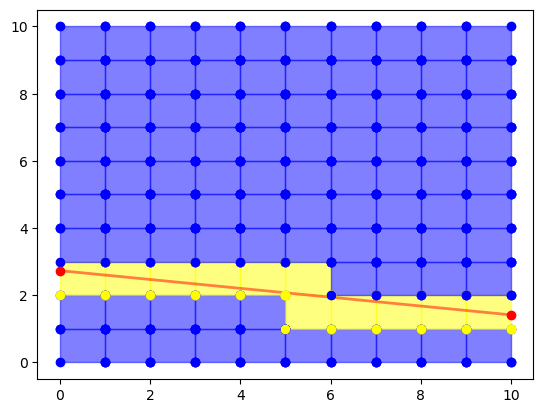

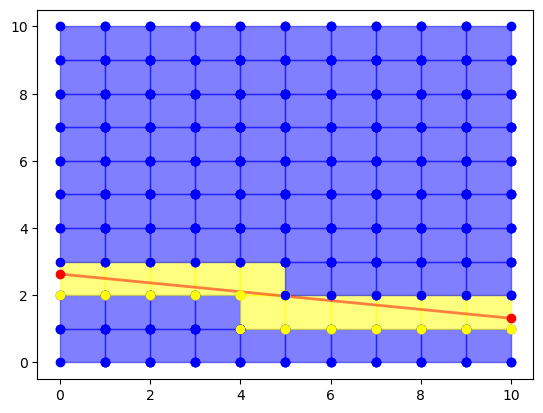

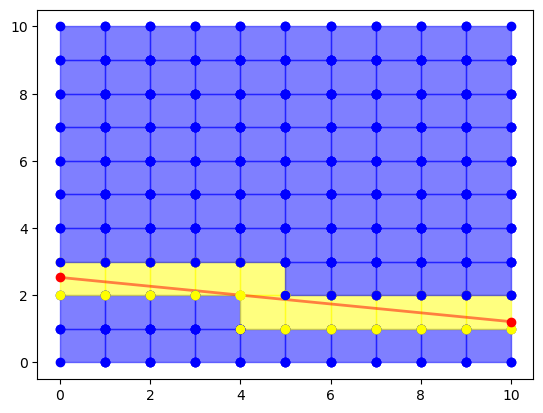

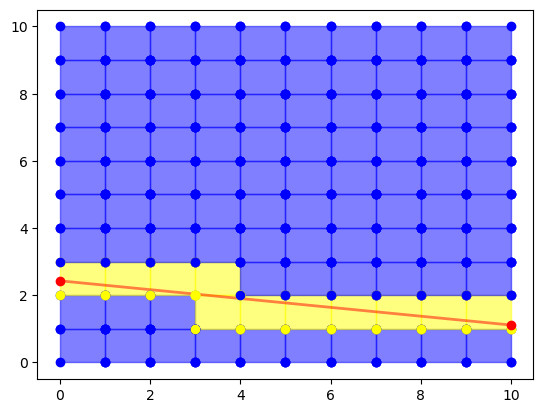

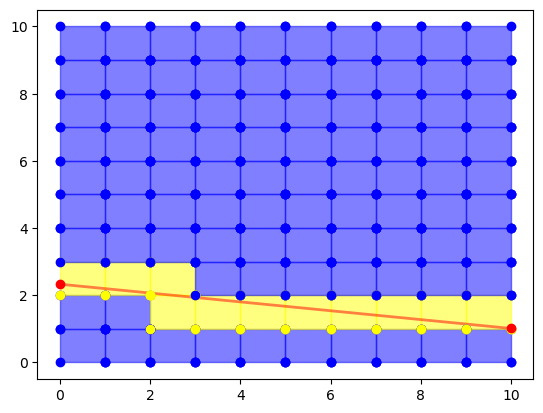

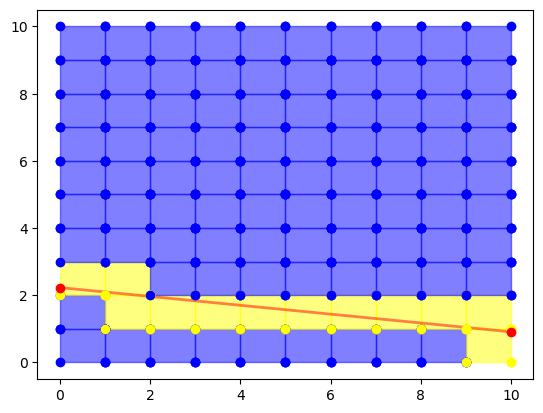

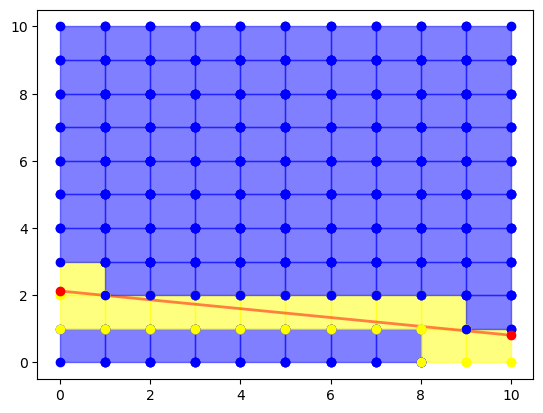

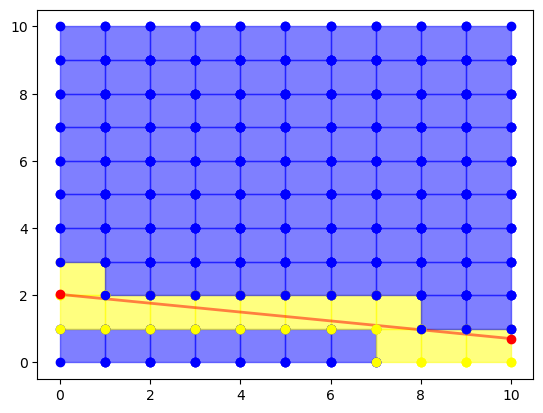

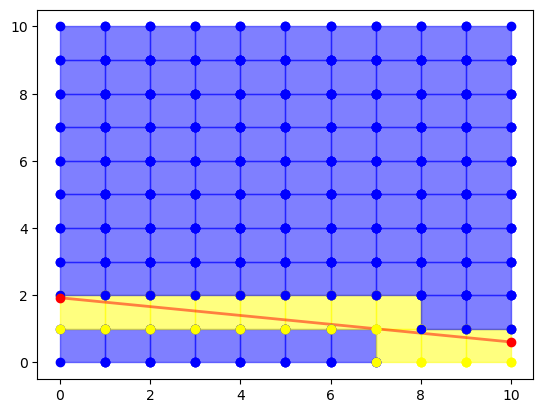

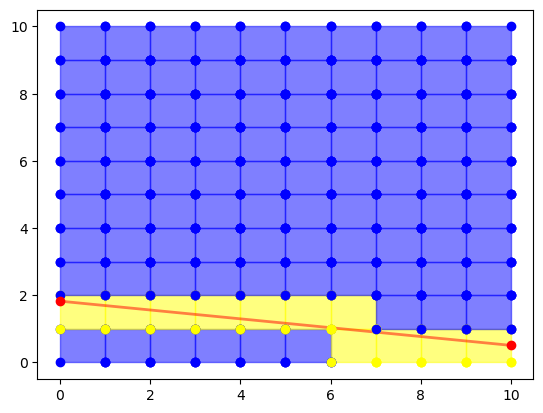

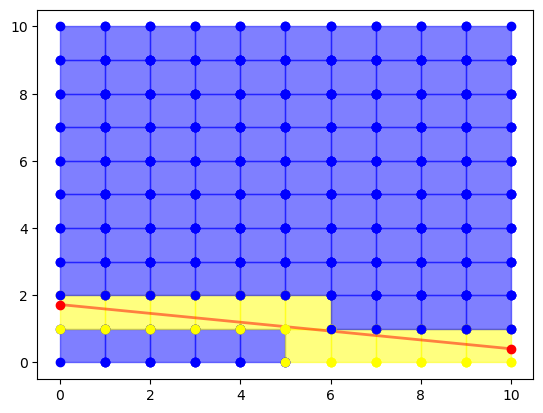

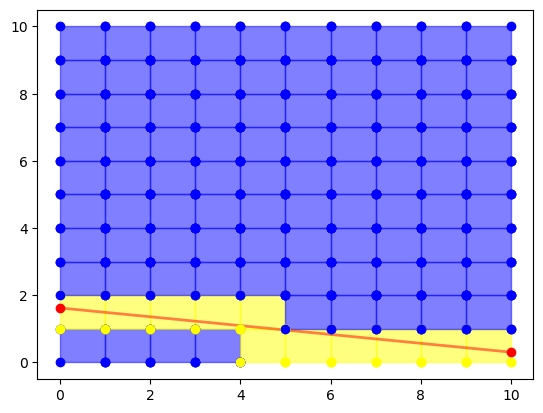

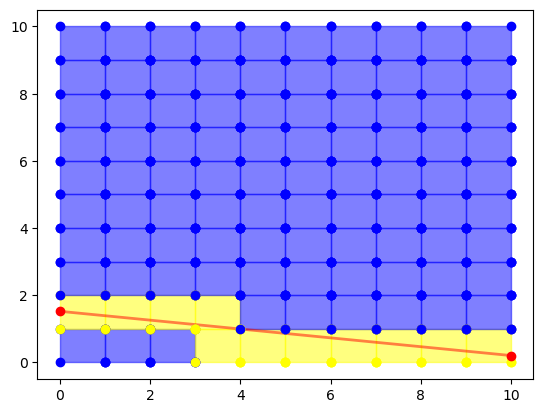

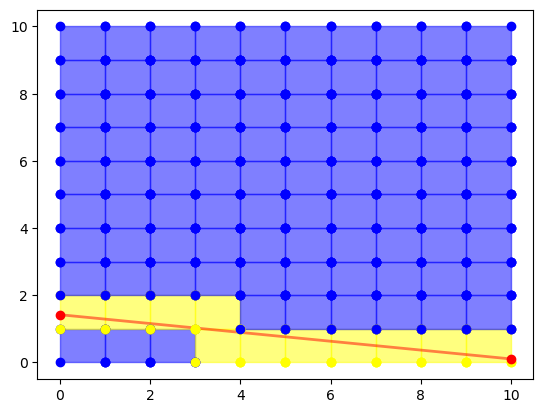

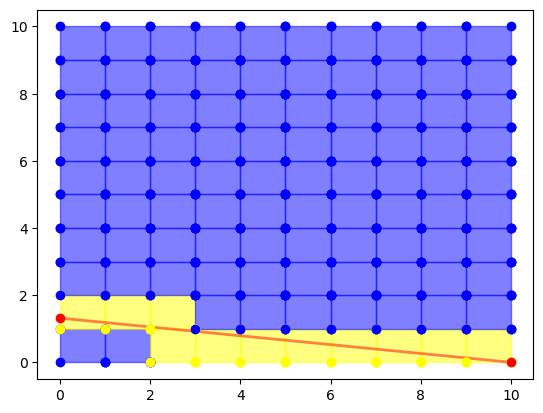

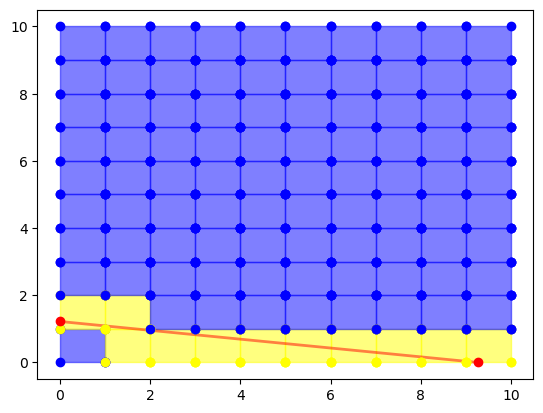

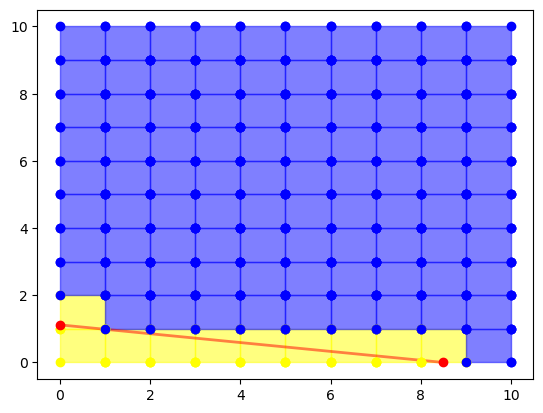

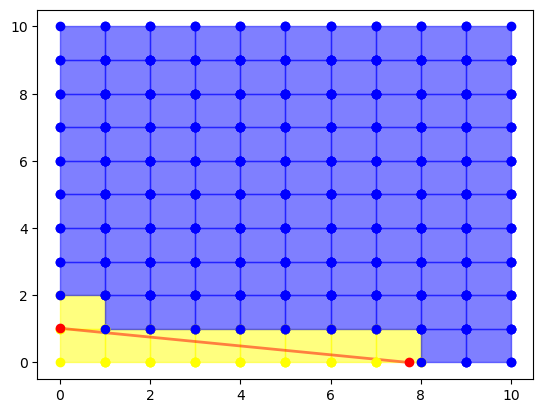

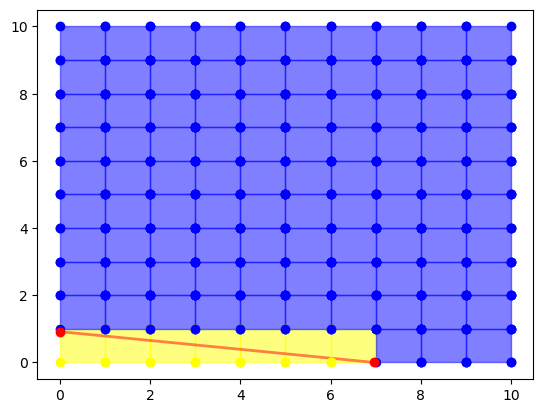

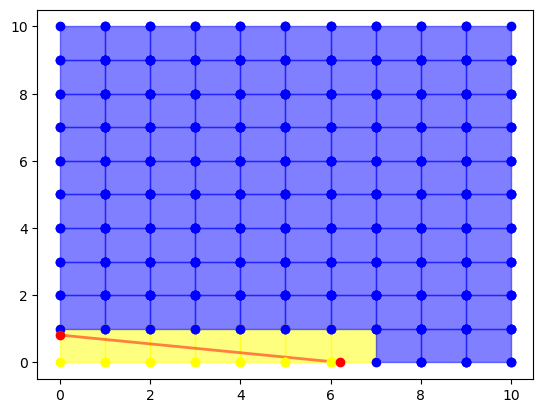

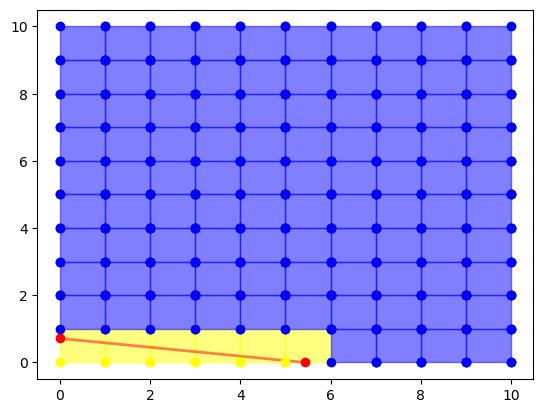

In [5]:
angle = -np.pi / 24

def get_intersecting_cells(ray, tree : shapely.STRtree):
    cell_idxs = tree.query(ray, predicate="intersects")
    cells = [tree.geometries.take(i) for i in cell_idxs]
    return cells

def test_intersecting_cells(offset, angle):
    ray = generate_ray(offset, angle)
    if ray is None:
        return
    intersecting_cells = get_intersecting_cells(ray, tree)
    
    fig, ax = plt.subplots()
    for cell in cells:
        if cell in intersecting_cells:
            shapely.plotting.plot_polygon(cell, color='yellow', alpha=0.5, ax=ax)
        else:
            shapely.plotting.plot_polygon(cell, color='blue', alpha=0.5, ax=ax)
            
    shapely.plotting.plot_line(ray, color='red', alpha=0.5, ax=ax)
    
for offset in np.arange(-5, 5, 0.1):
    test_intersecting_cells(offset, angle)

C:\Users\bpeco\AppData\Local\Temp\ipykernel_18900\661280314.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


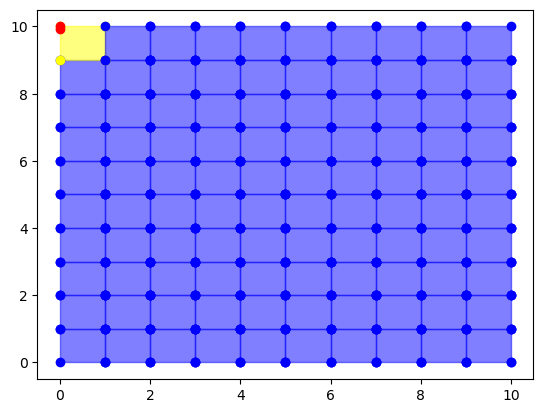

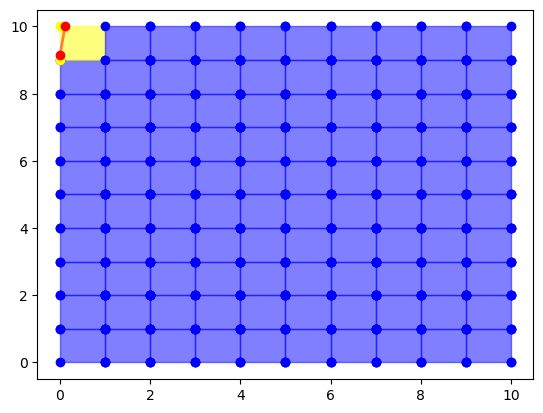

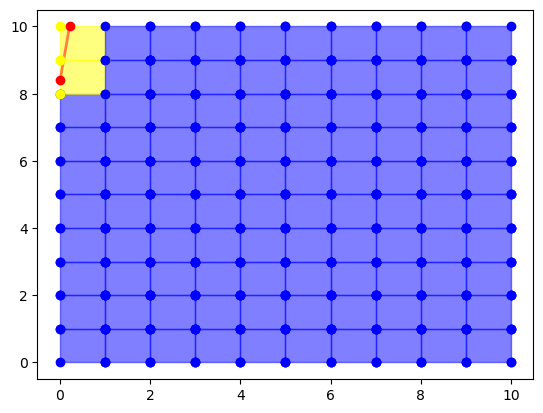

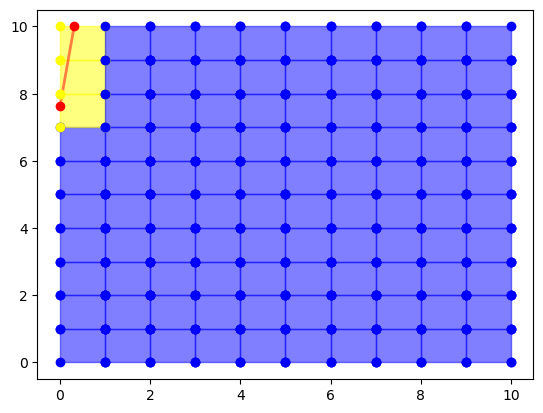

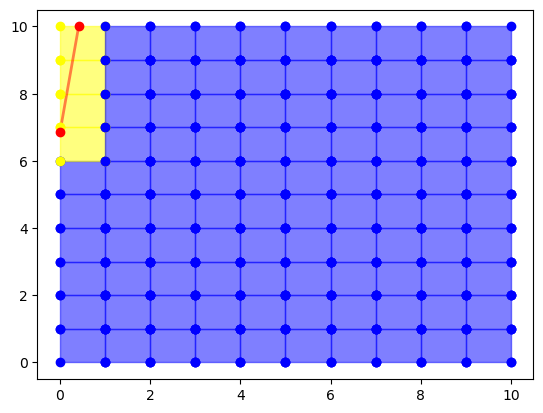

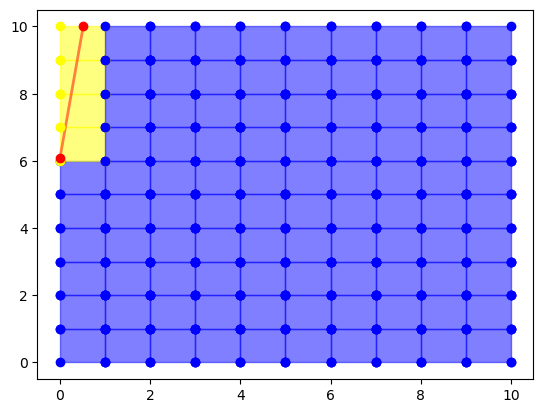

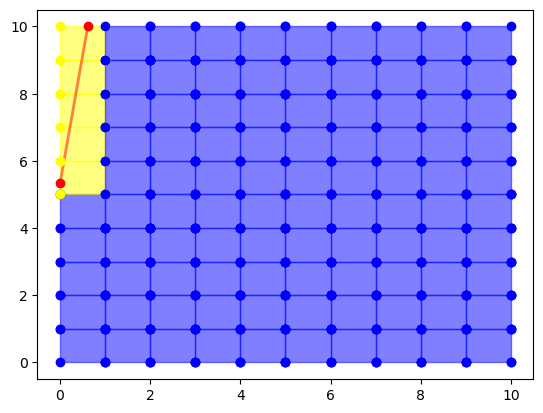

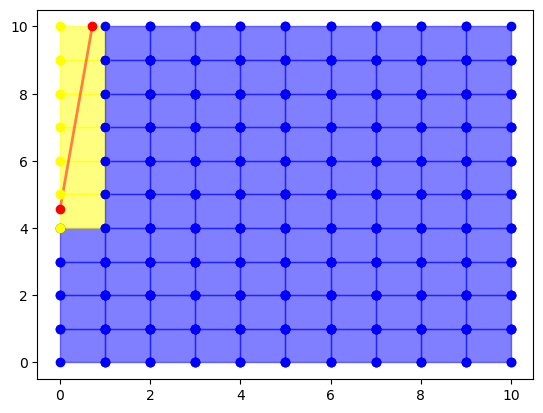

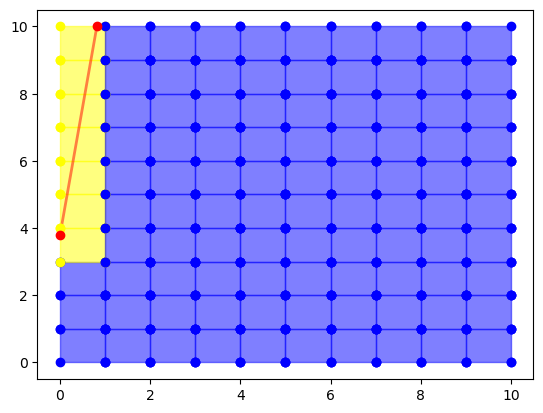

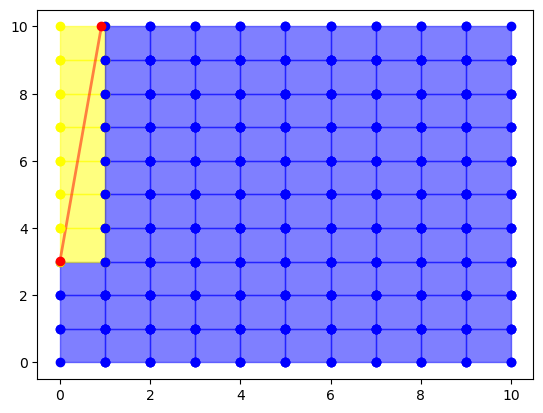

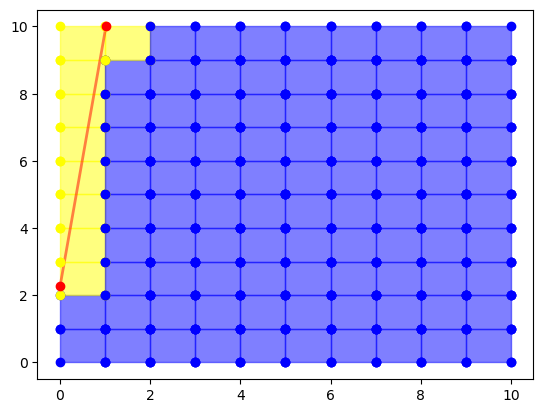

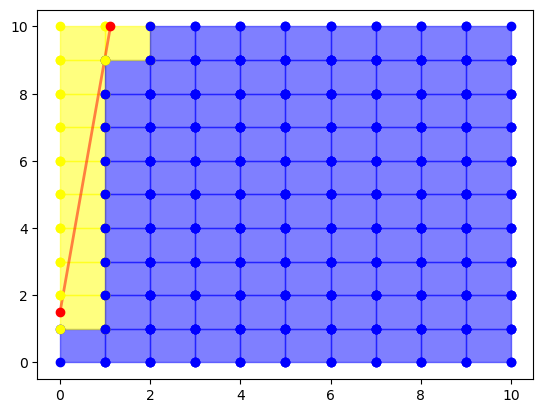

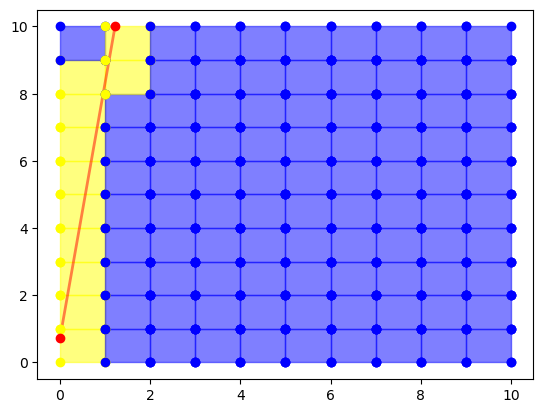

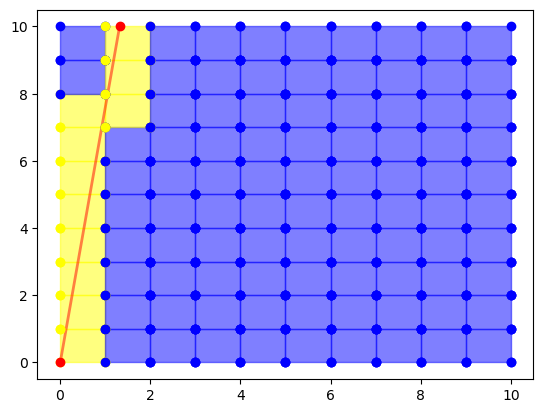

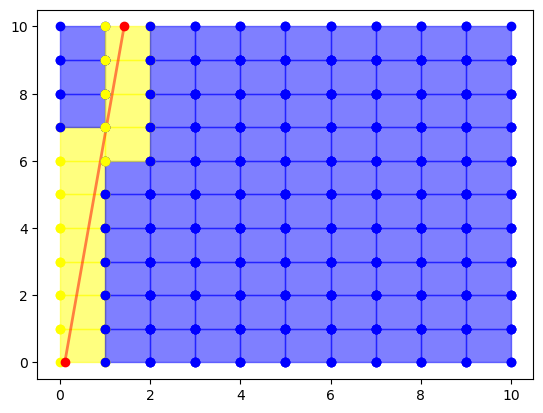

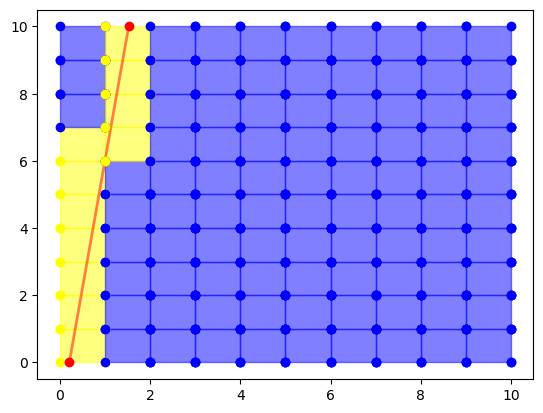

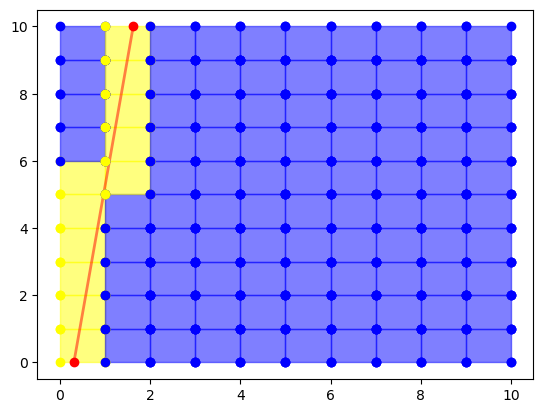

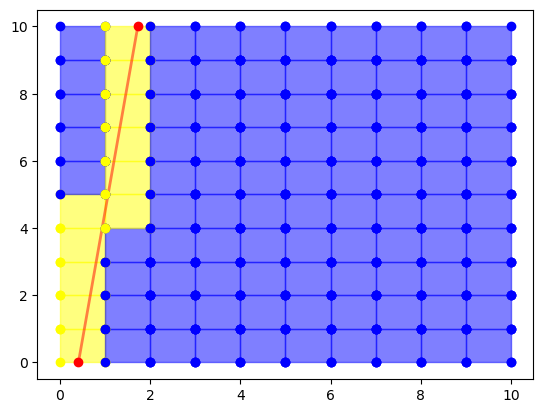

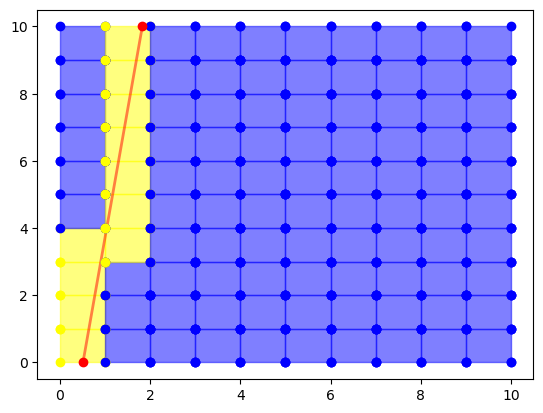

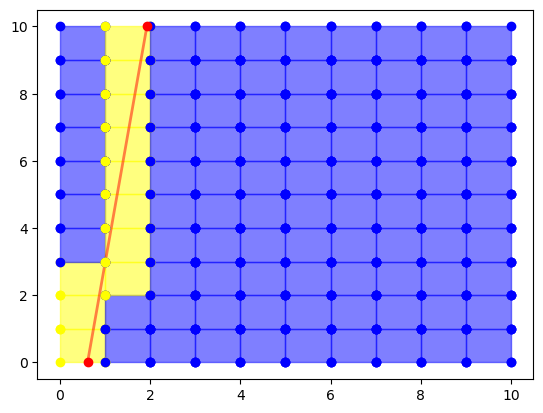

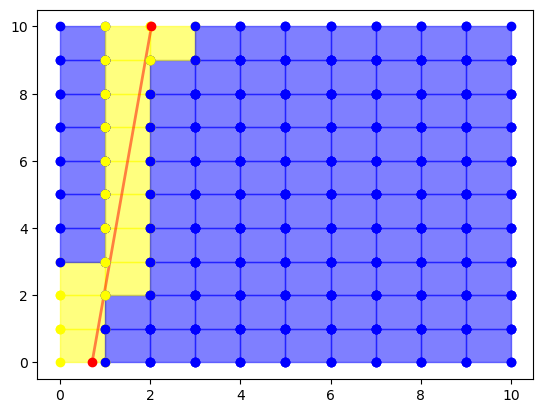

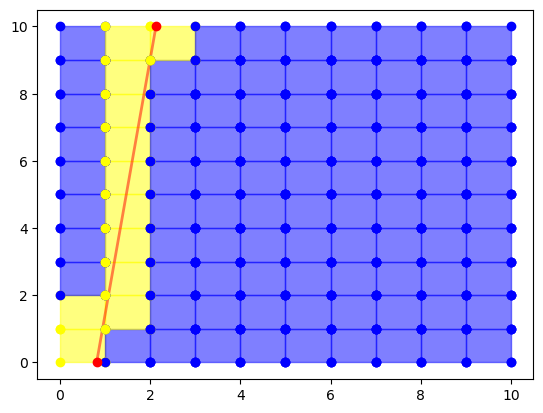

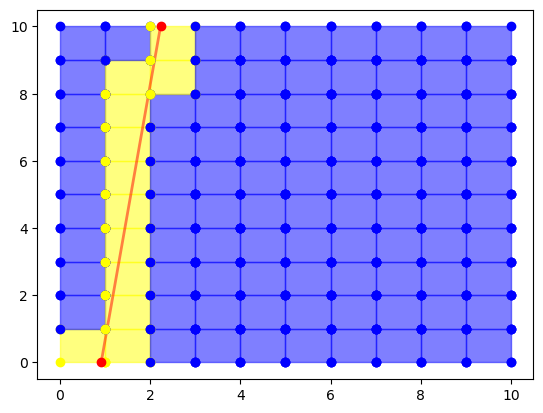

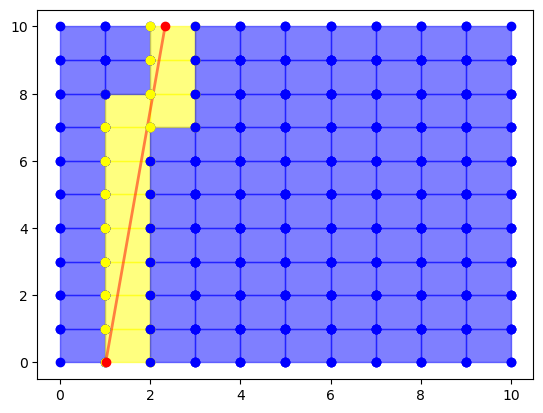

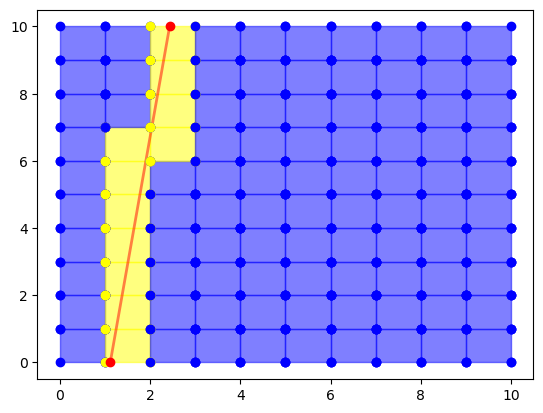

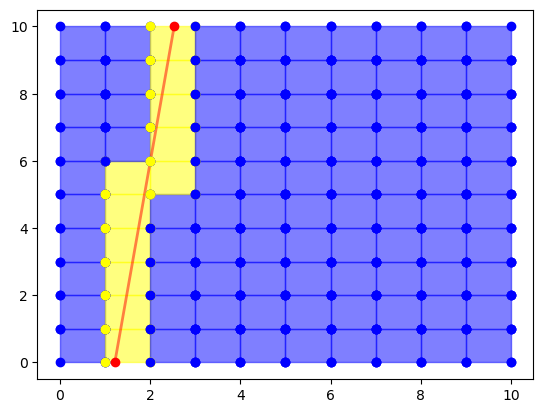

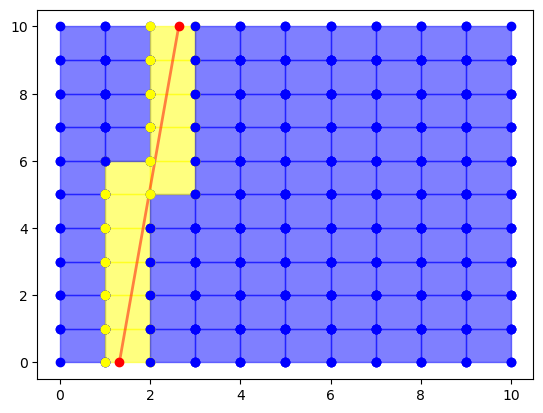

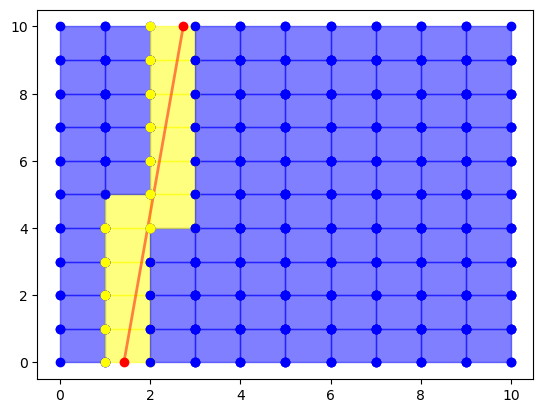

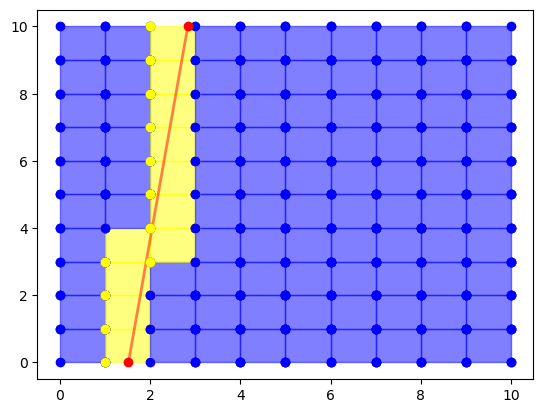

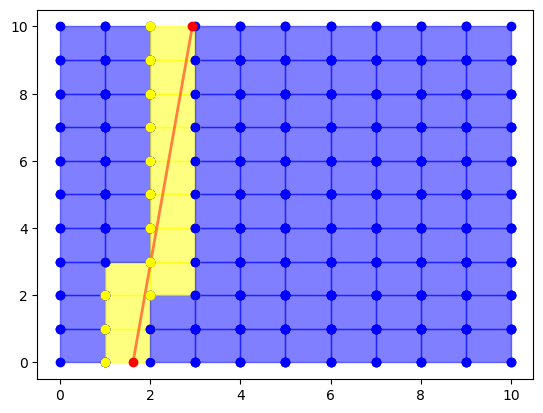

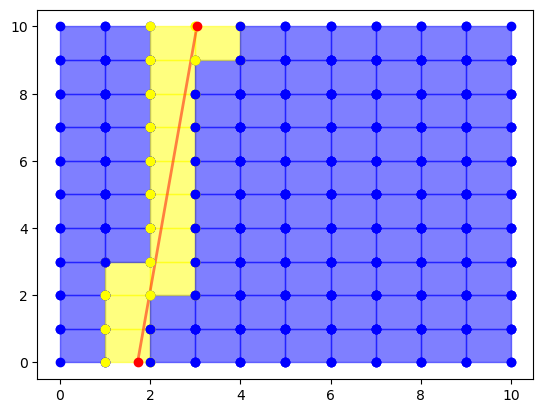

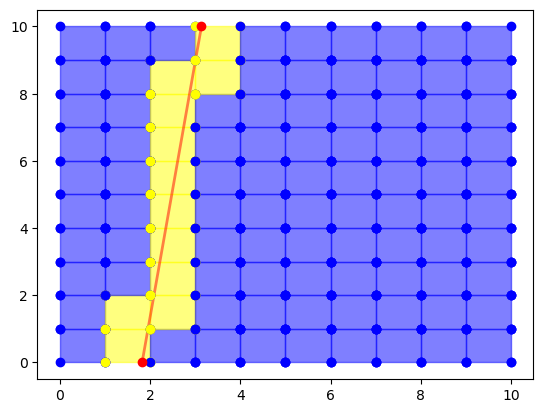

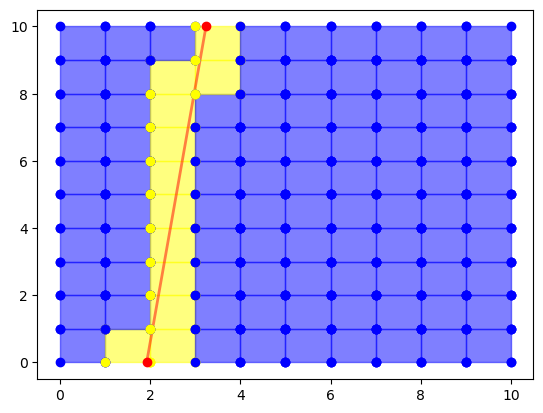

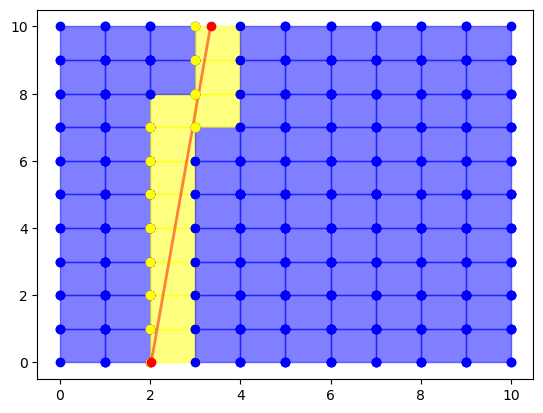

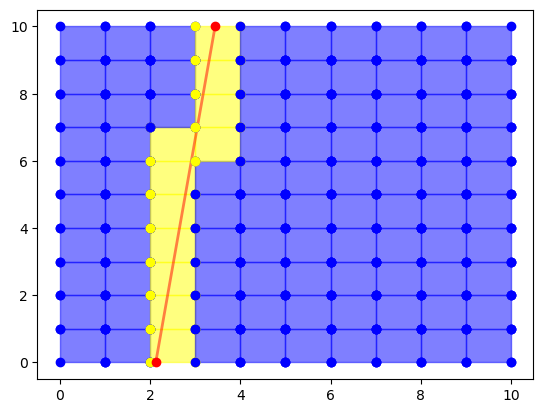

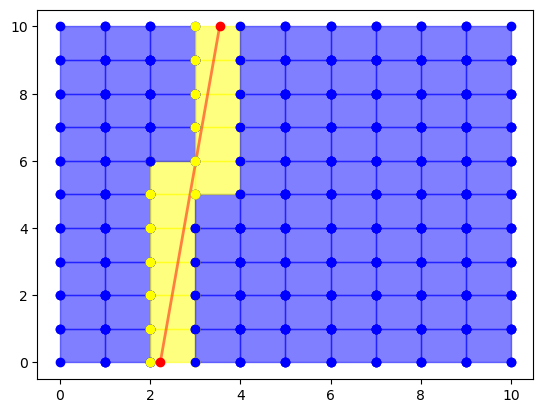

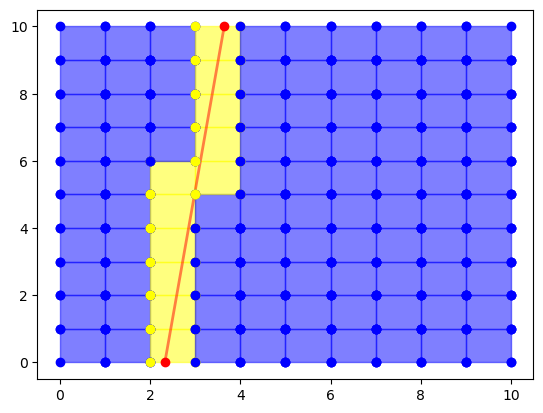

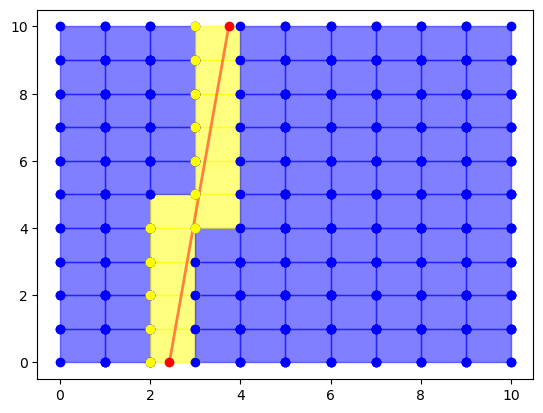

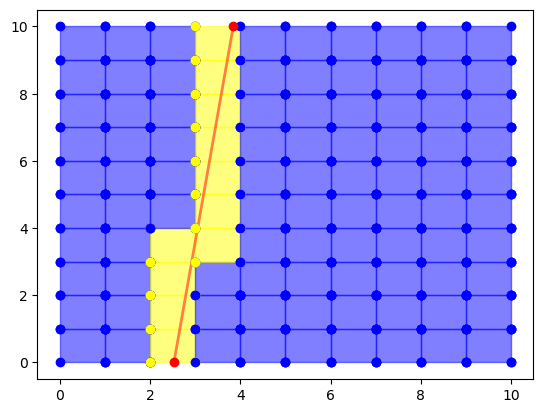

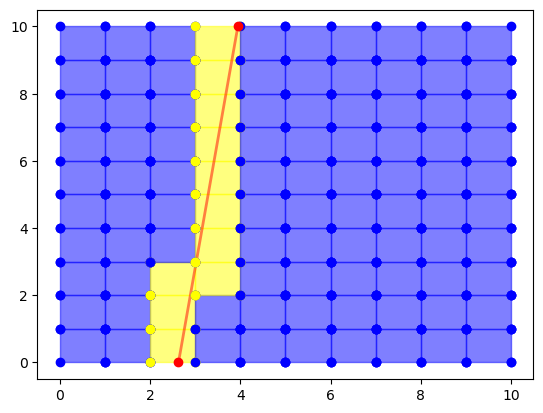

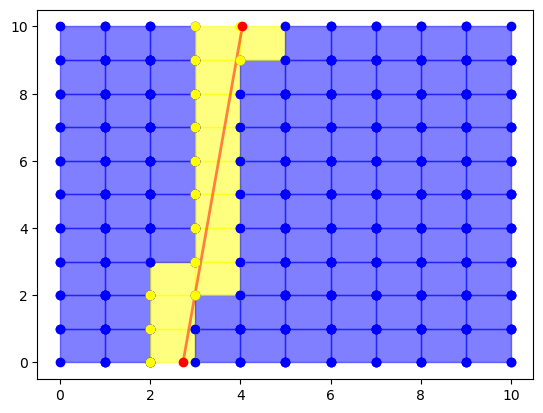

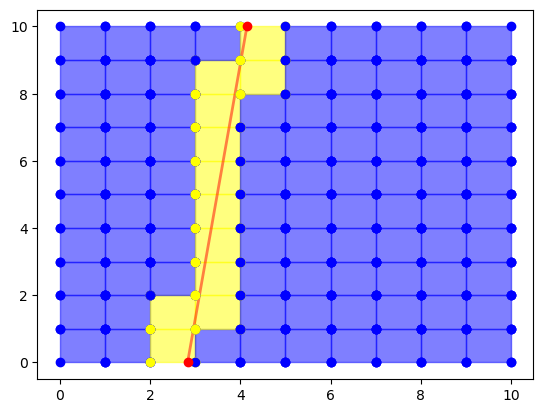

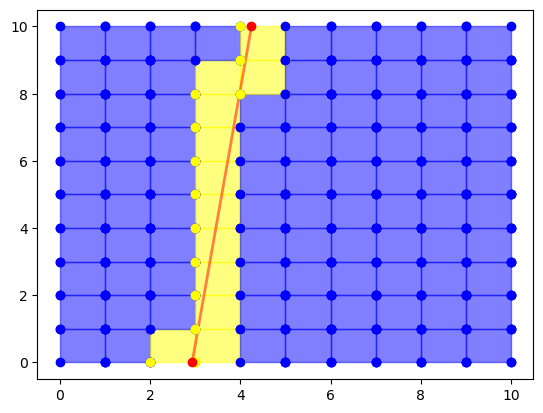

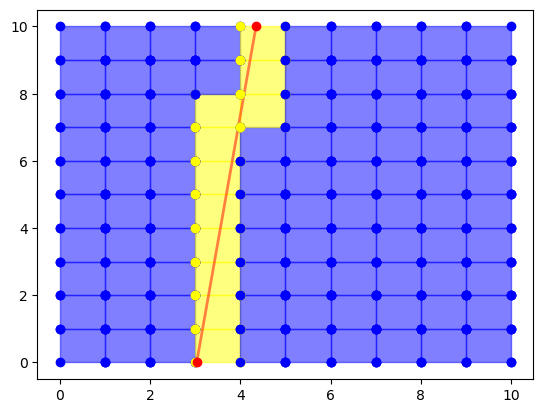

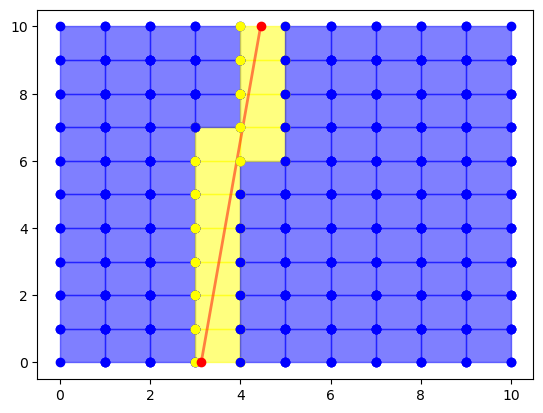

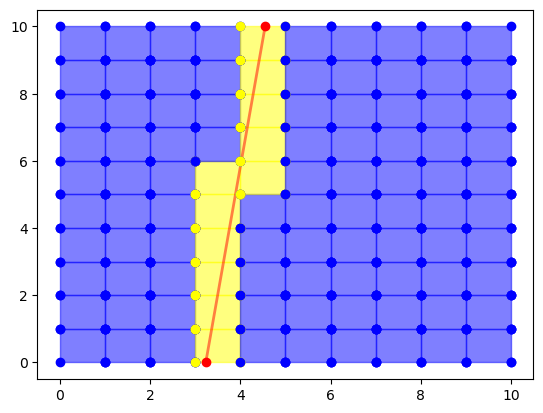

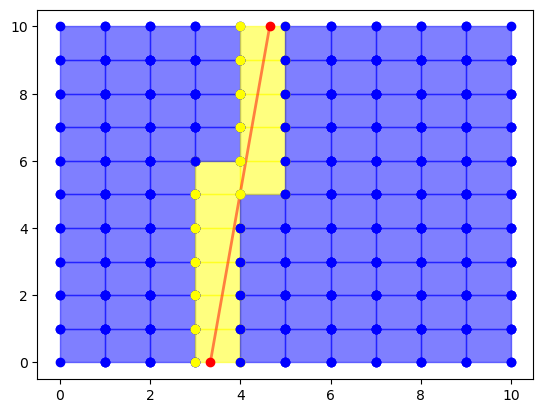

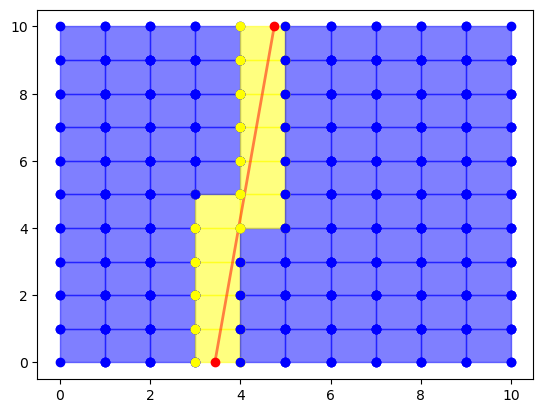

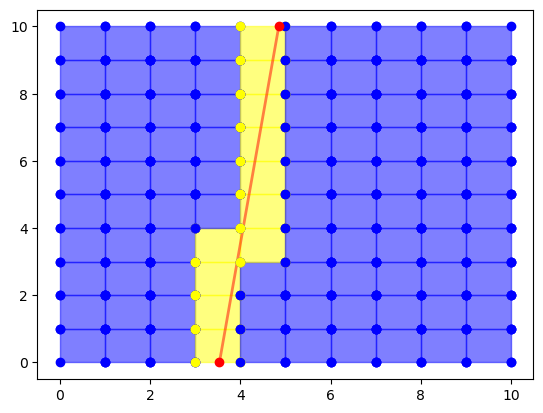

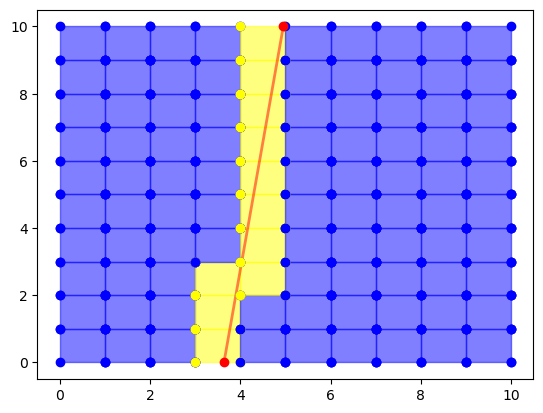

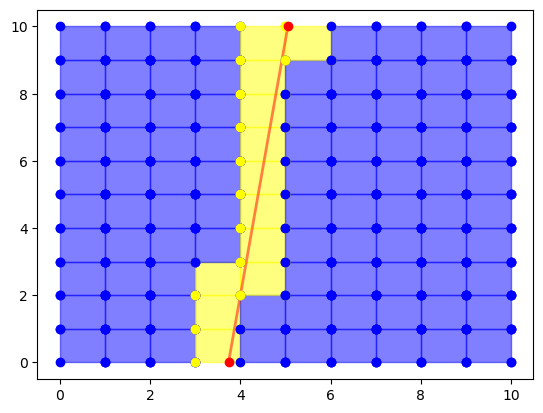

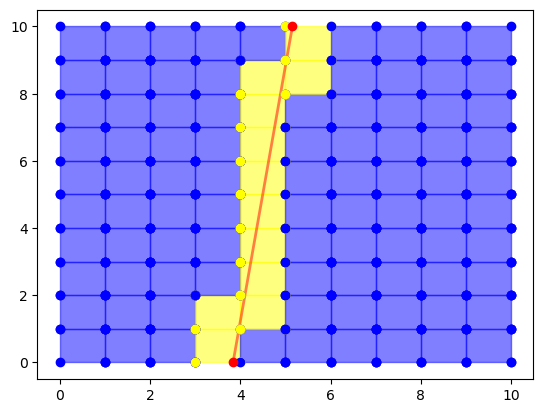

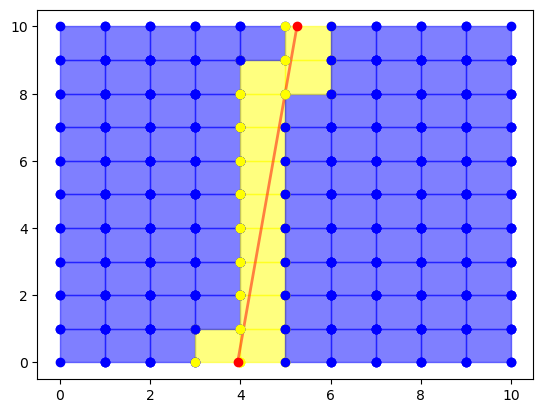

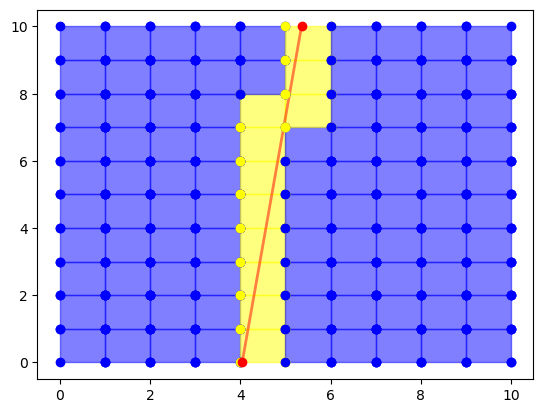

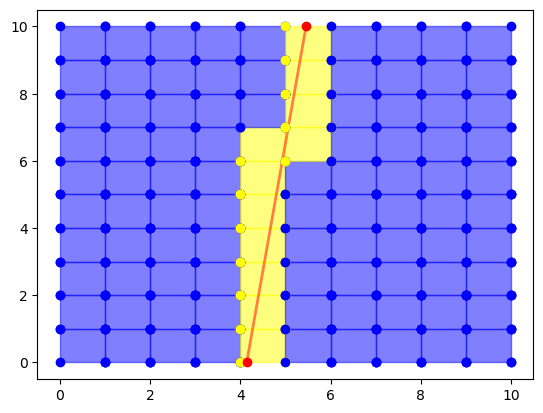

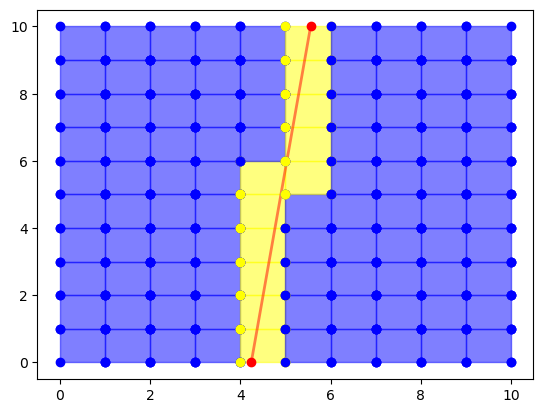

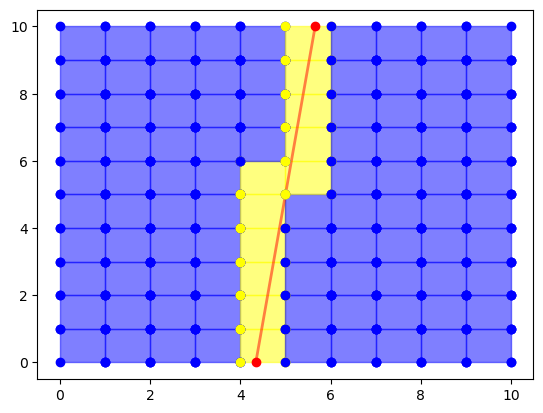

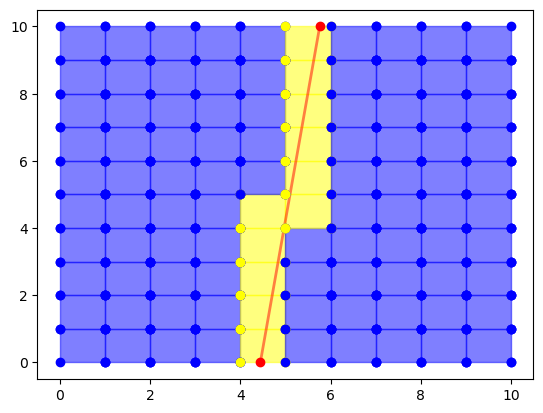

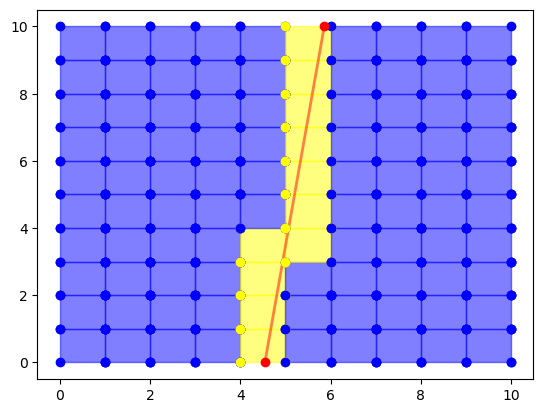

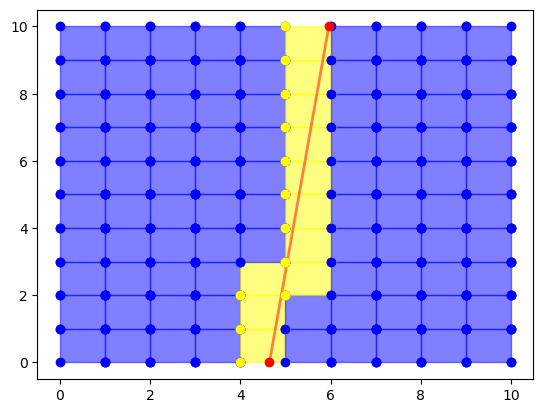

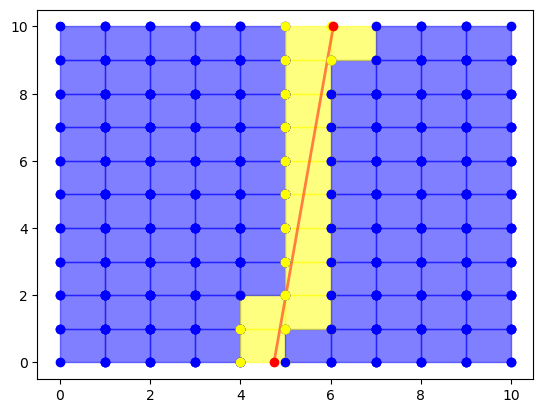

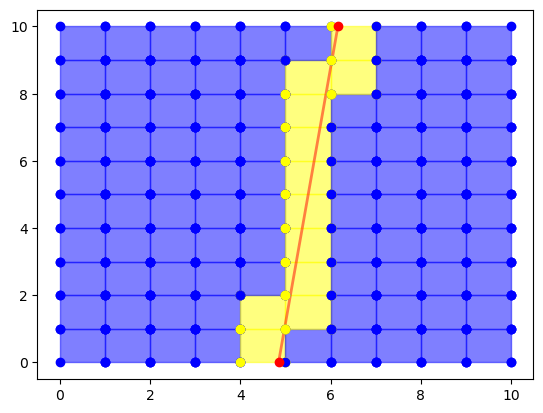

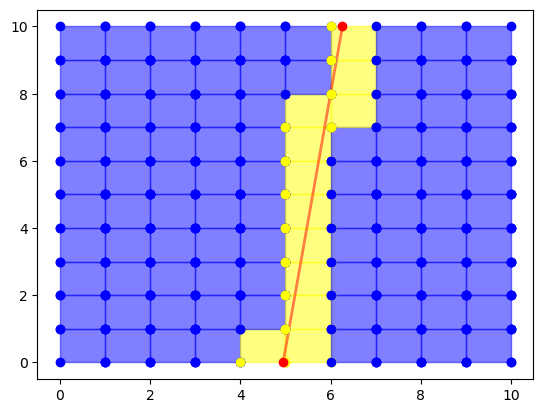

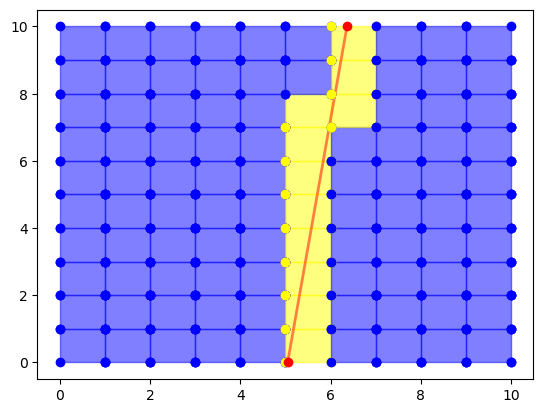

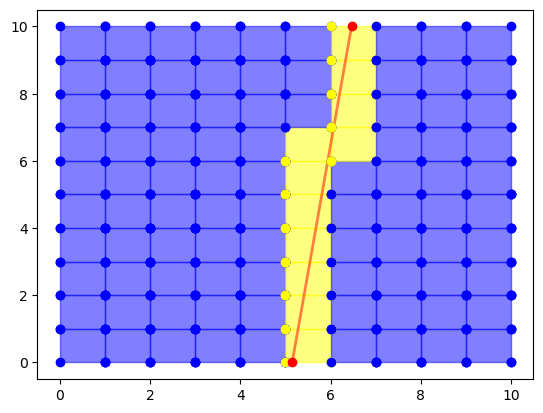

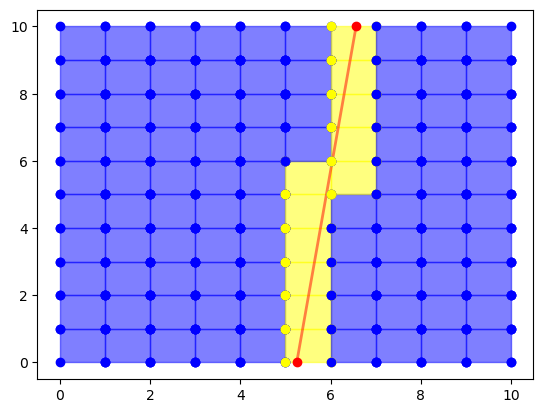

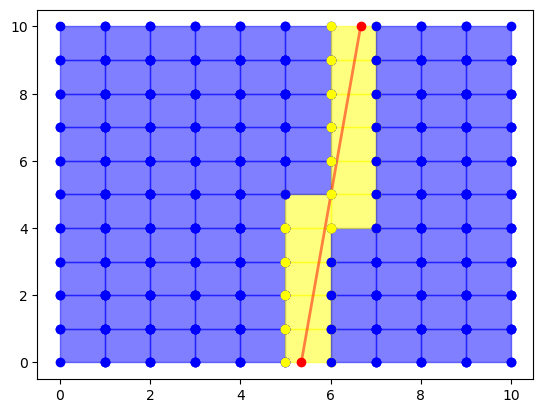

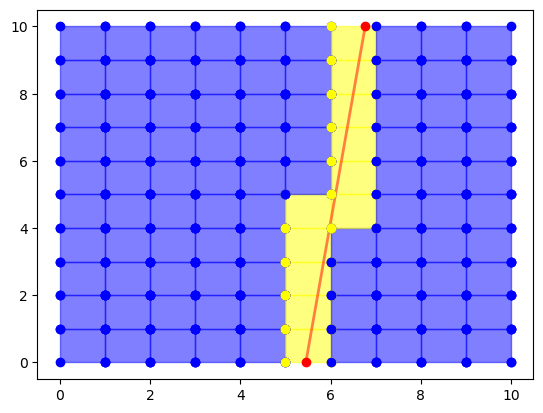

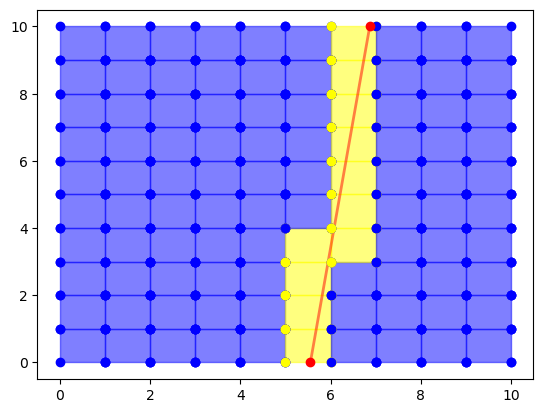

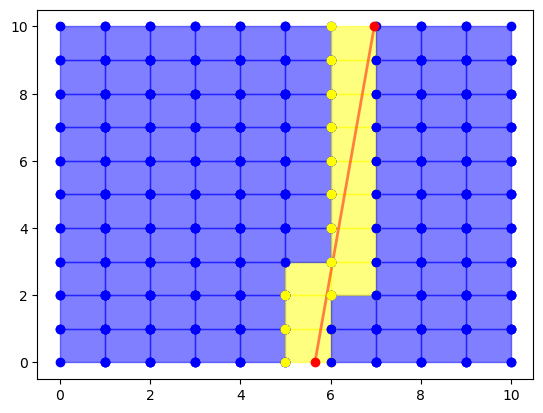

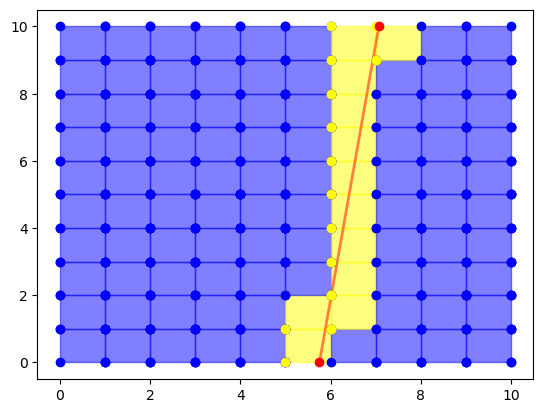

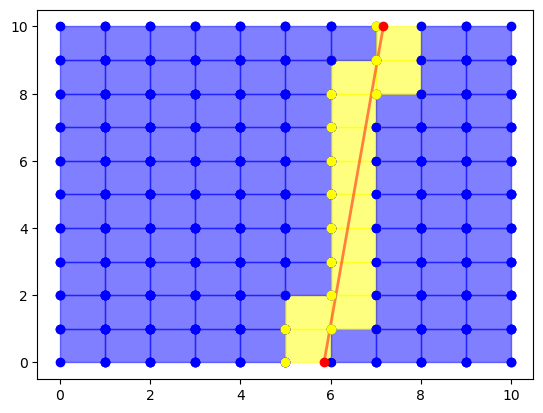

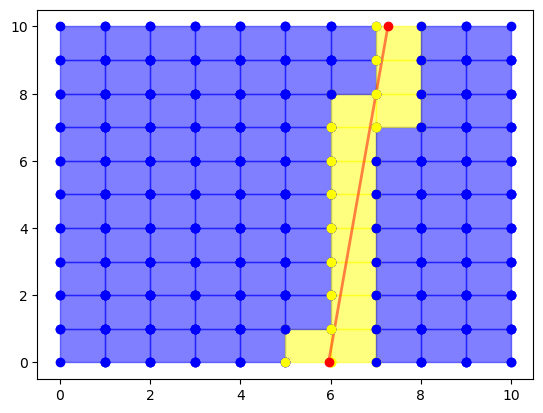

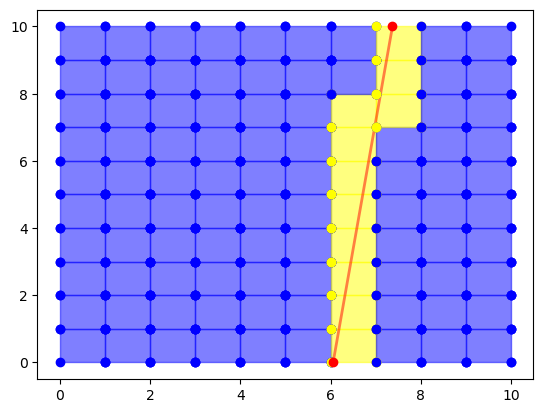

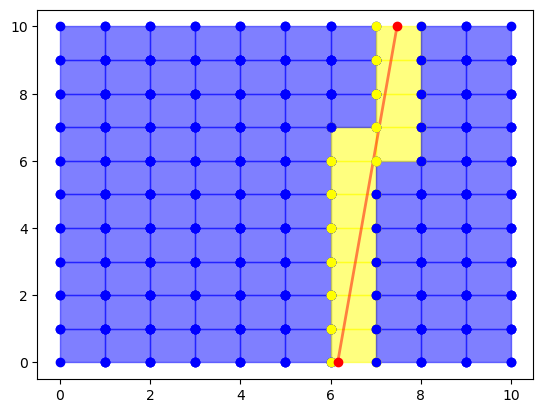

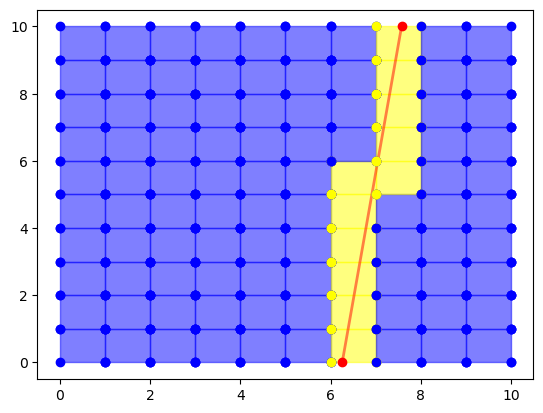

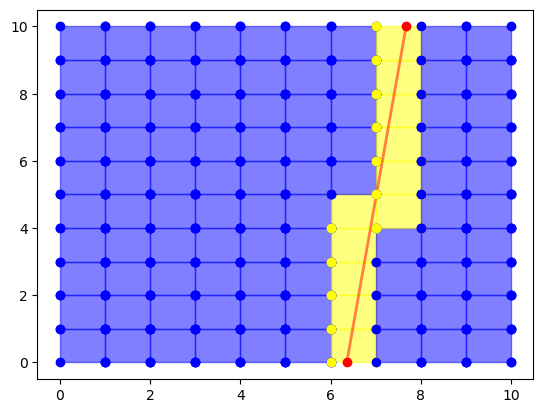

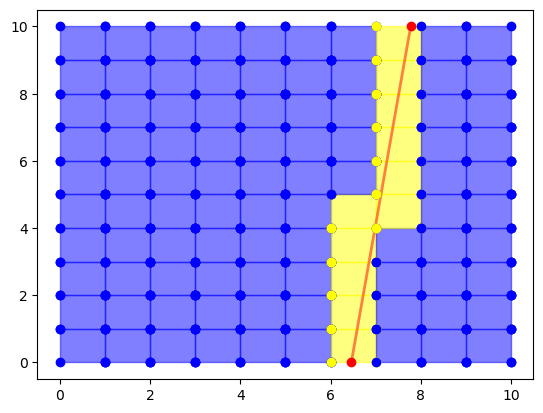

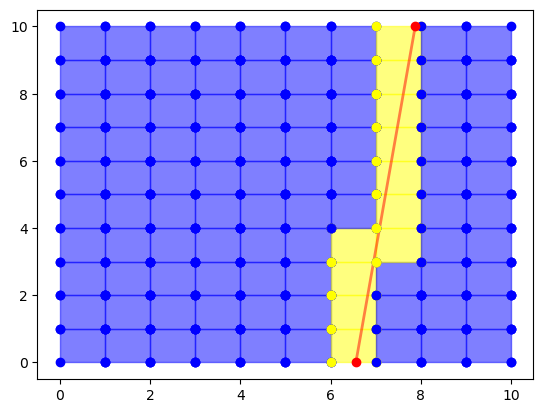

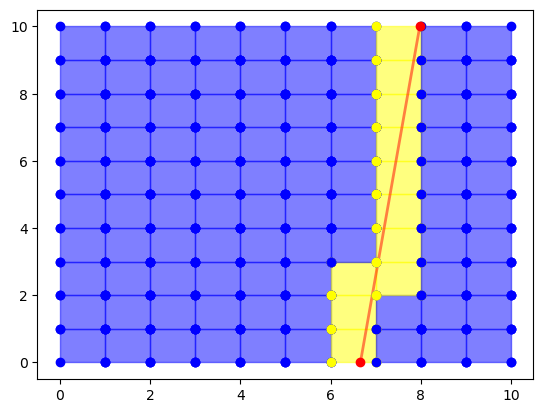

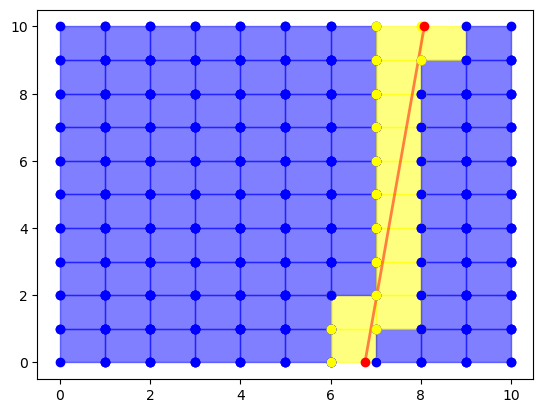

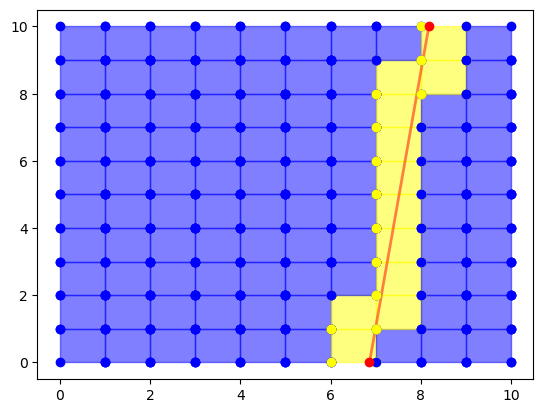

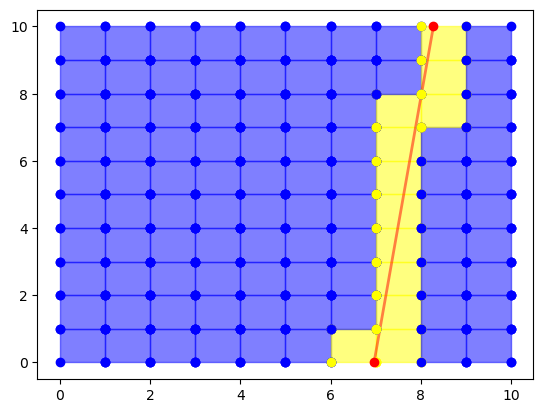

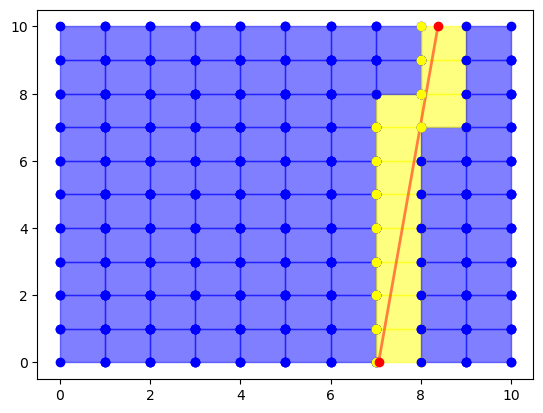

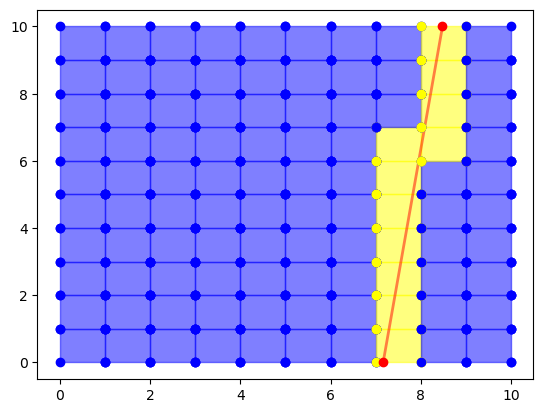

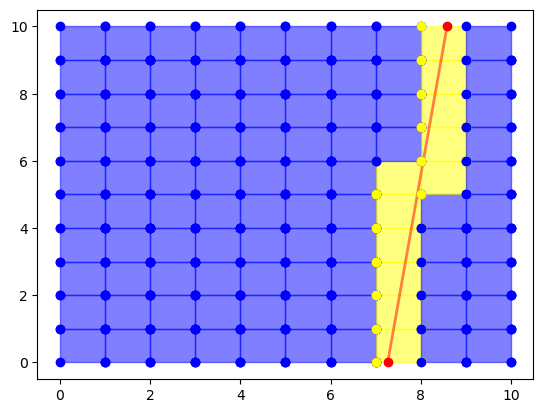

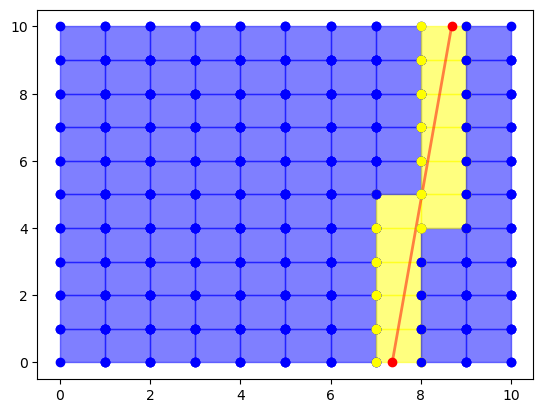

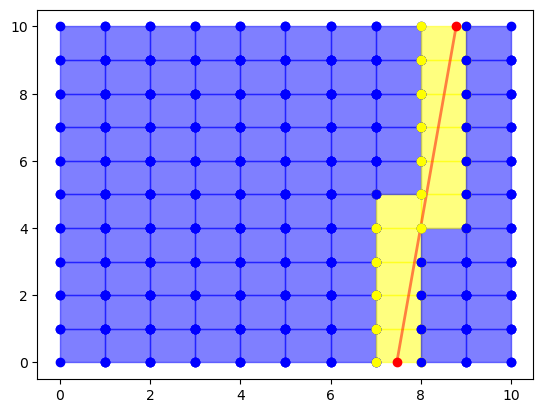

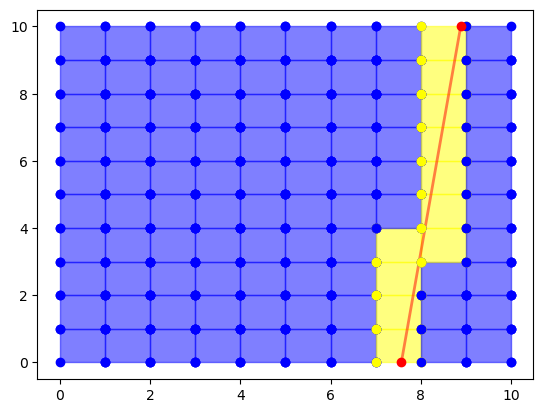

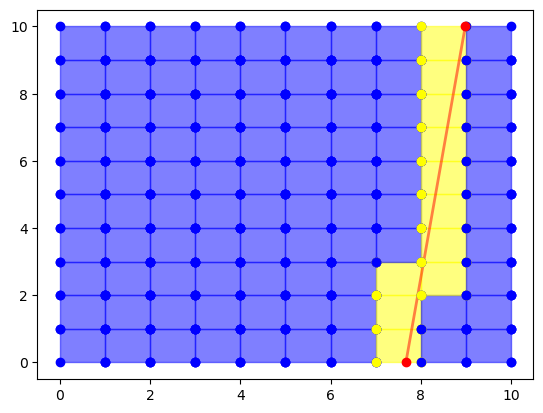

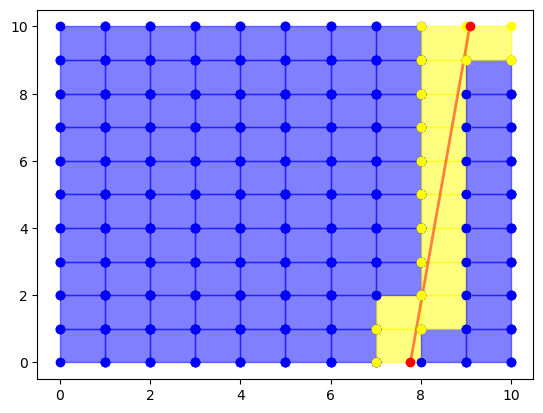

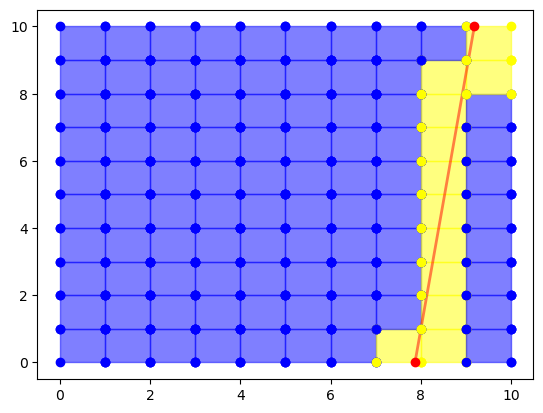

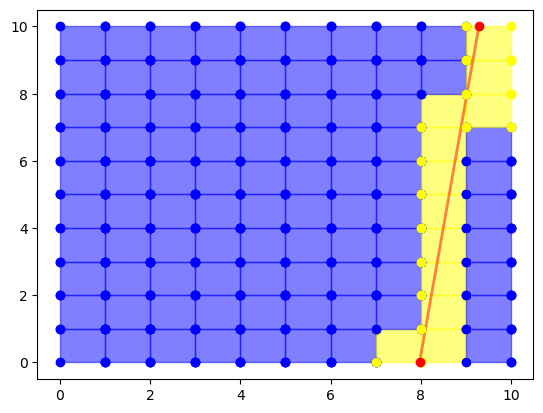

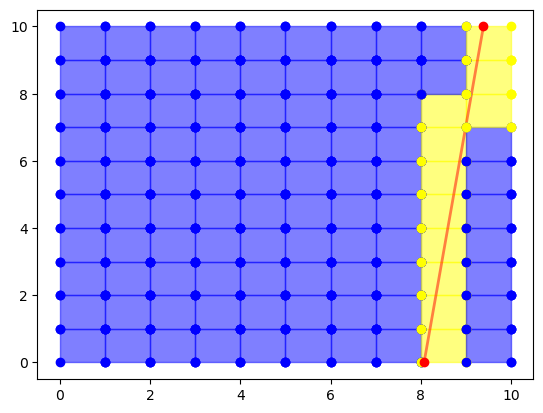

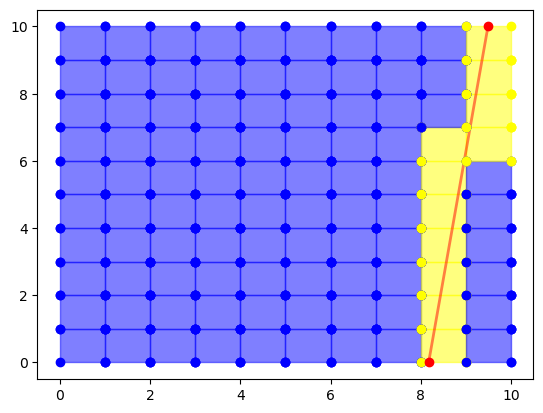

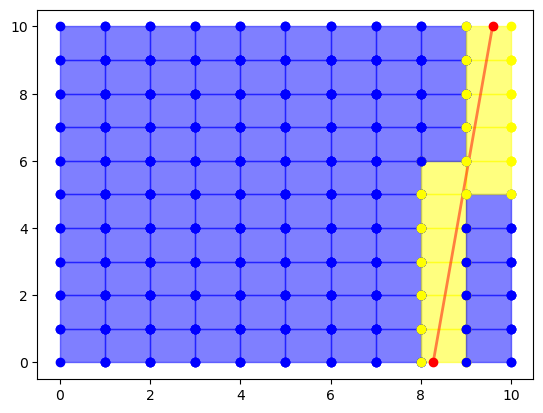

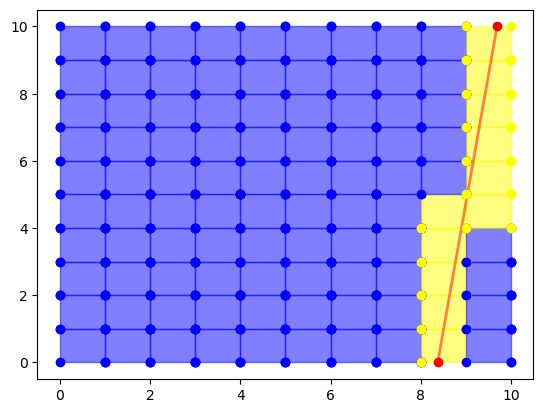

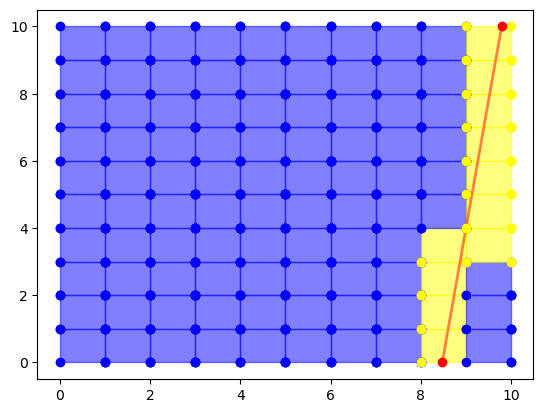

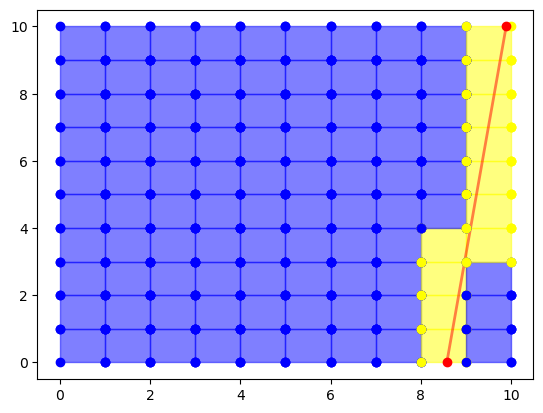

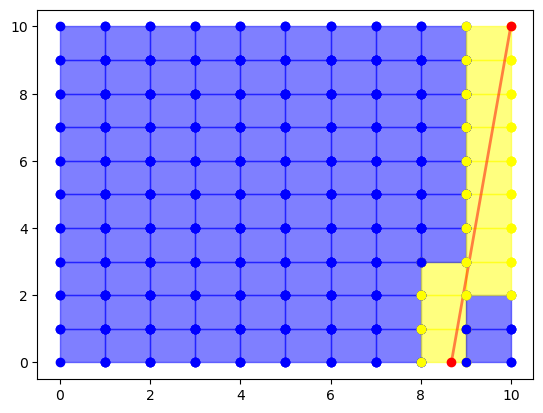

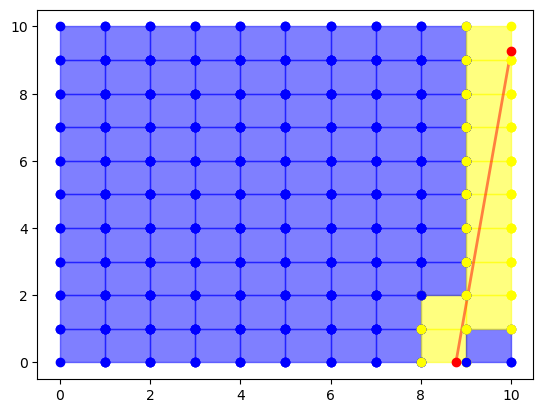

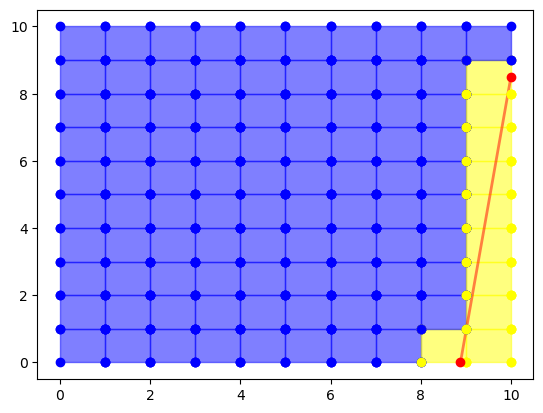

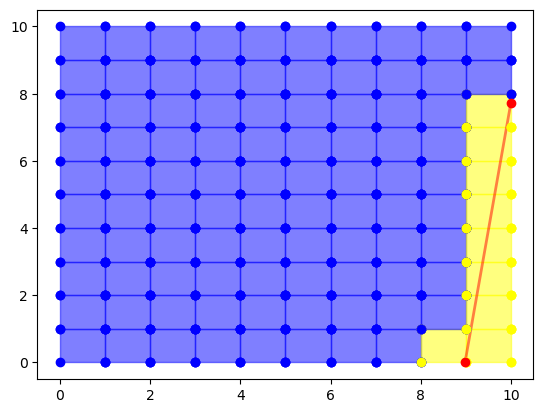

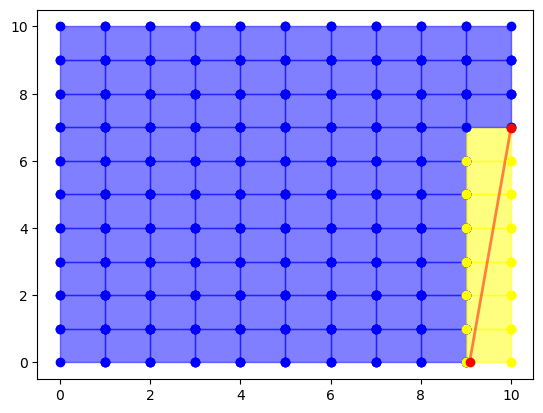

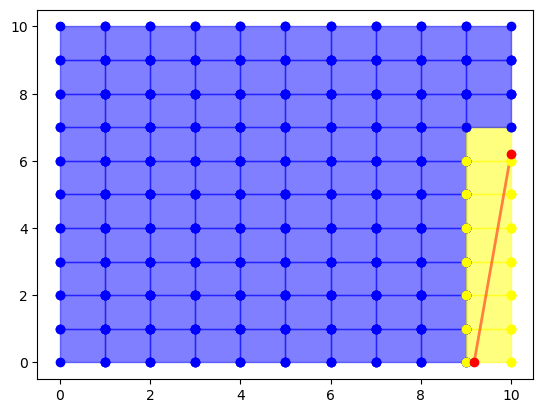

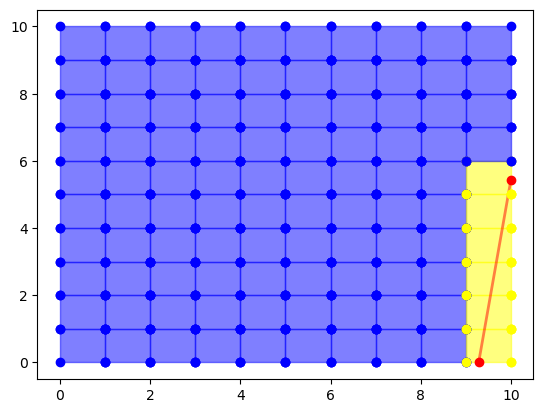

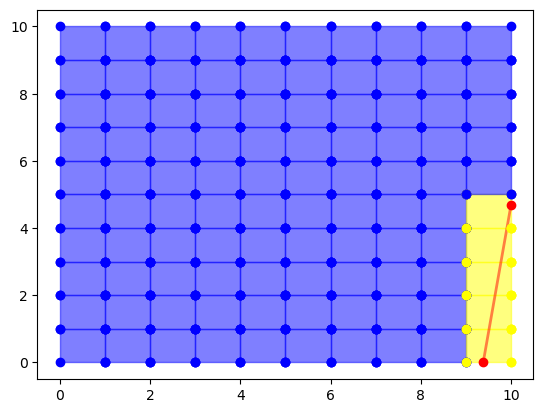

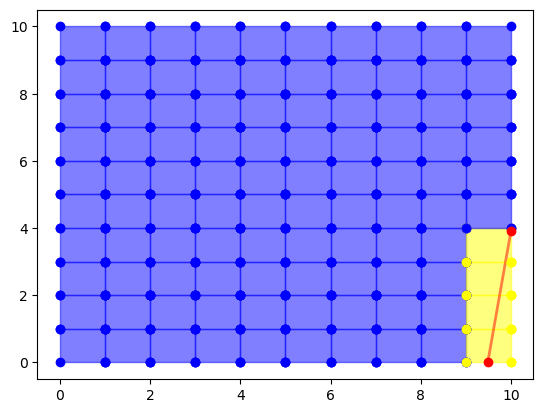

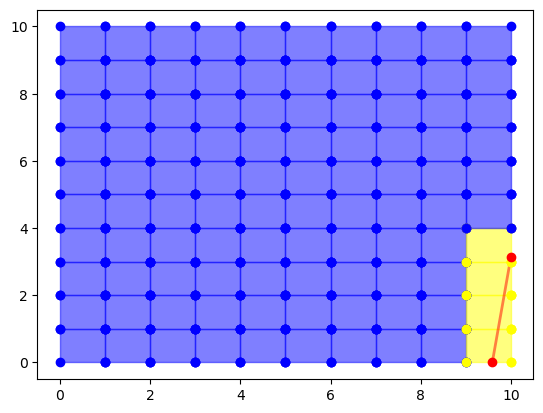

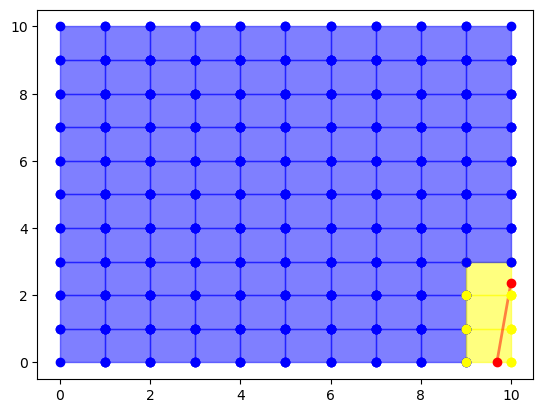

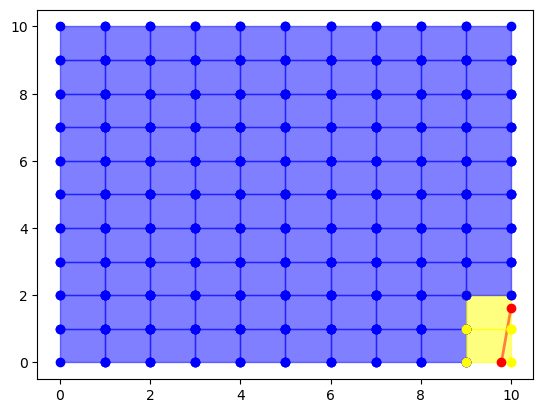

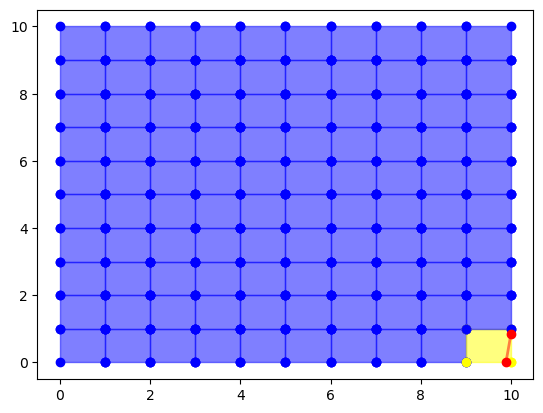

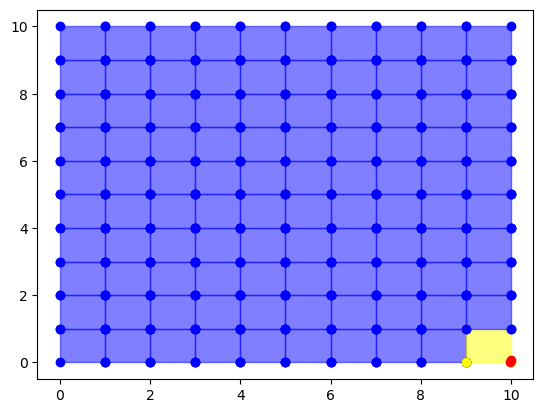

In [6]:
for offset in np.arange(-7, 7, 0.1):
    test_intersecting_cells(offset, 11 * np.pi / 24)